In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from abnumber import Chain, Position
from bin.utils import heading
from bin.evaluation import plot_oasis_curves, plot_overlap, plot_overlap_boxplot, plot_overlap_venns, \
    plot_overlap_venn, collect_positions, read_oasis_chains
import matplotlib
matplotlib.rcParams['hatch.linewidth'] = 0.8
from scipy import stats
from abnumber import sort_positions

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
TASK_DIR = '../../data/tasks/humab_25_pairs'

In [72]:
PARENTAL = dict(
    name='Parental',
    color='#aaaaaa',
    ls='-',
    path=os.path.join(TASK_DIR, 'pairs/parental')
)

EXPERIMENTAL = dict(
    name='Experimental',
    color='tab:green',
    ls='-',
    path=os.path.join(TASK_DIR, 'pairs/experimental')
)

HUMAB = dict(
    name='Hu-mAb',
    color='#ff9698',
    ls='-',
    path=os.path.join(TASK_DIR, 'pairs/humab')
)

VERNIER_GRAFT = dict(
    name='Vernier graft',
    color='tab:orange',
    ls='--',
    path=os.path.join(TASK_DIR, 'cdr_grafts/vernier_grafts')
)

STRAIGHT_GRAFT = dict(
    name='Straight graft',
    color='tab:cyan',
    ls='--',
    path=os.path.join(TASK_DIR, 'cdr_grafts/straight_grafts')
)

SAPIENS1 = dict(
    name='Sapiens*1',
    color='#a020c0',
    ls='-',
    path=os.path.join(TASK_DIR, 'predicted/sapiens1')
)

SAPIENS2 = dict(
    name='Sapiens*2',
    color='#a020c0',
    ls='-',
    path=os.path.join(TASK_DIR, 'predicted/sapiens2')
)

SAPIENS3 = dict(
    name='Sapiens*3',
    color='#a020c0',
    ls='-',
    path=os.path.join(TASK_DIR, 'predicted/sapiens3')
)

SAPIENS4 = dict(
    name='Sapiens*4',
    color='#a020c0',
    ls='-',
    path=os.path.join(TASK_DIR, 'predicted/sapiens4')
)

SAPIENS = SAPIENS3

METHODS = [
    PARENTAL,
    EXPERIMENTAL,
    SAPIENS1,
    SAPIENS2,
    SAPIENS3,
    SAPIENS4,
    HUMAB,
    VERNIER_GRAFT,
    STRAIGHT_GRAFT
]

HUMANIZED_METHODS = [
    EXPERIMENTAL,
    SAPIENS,
    HUMAB,
    STRAIGHT_GRAFT,
    VERNIER_GRAFT,
]

HUMANIZED_METHOD_NAMES = [method['name'] for method in HUMANIZED_METHODS]


SELECTED_METHODS = [
    PARENTAL,
    EXPERIMENTAL,
    SAPIENS,
    HUMAB,
    STRAIGHT_GRAFT,
    VERNIER_GRAFT,
]

SELECTED_METHOD_NAMES = [method['name'] for method in SELECTED_METHODS]


COLORS = {method['name']: method['color'] for method in METHODS}
LINESTYLES = {method['name']: method['ls'] for method in METHODS}

HUMANIZED_COLORS = {method['name']: method['color'] for method in HUMANIZED_METHODS}

SELECTED_COLORS = {method['name']: method['color'] for method in SELECTED_METHODS}

In [4]:
parental_heavy, parental_light, _, _ = read_oasis_chains(PARENTAL['path'] + '_oasis.xlsx')
NAMES = parental_heavy.index.values

In [5]:
experimental_heavy, experimental_light, experimental_heavy_germlines, experimental_light_germlines = read_oasis_chains(
    EXPERIMENTAL['path'] + '_oasis.xlsx', 
    index=NAMES
)

print(parental_heavy[0].align(experimental_heavy[0], experimental_heavy_germlines[0]))
print()
print(parental_light[0].align(experimental_light[0], experimental_light_germlines[0]))

EVKLQQSGPGLVTPSQSLSITCTVSGFSLSDYGVHWVRQSPGQGLEWLGVIWAGGGTNYNSALMSRKSISKDNSKSQVFLKMNSLQADDTAVYYCARDKGYSYYYSMDYWGQGTSVTVSS
||+|.|||.|||.|..||.++|..|||+.||||||||||+||+||||+..|||||||||.|++|.|.+||+||+|+.++|+||||+|+|.||||||||||||||||||||||||.|||||
EVQLVQSGGGLVQPGGSLRLSCAGSGFTFSDYGVHWVRQAPGKGLEWVSAIWAGGGTNYASSVMGRFTISRDNAKNSLYLQMNSLRAEDMAVYYCARDKGYSYYYSMDYWGQGTLVTVSS
||||||||||||||||||||||||||||||.|.+|||||||||||||||||..||||.||.||.|||||||||||||||||||||||||||||||||..........|||||||||||||
EVQLVQSGGGLVQPGGSLRLSCAGSGFTFSSYAMHWVRQAPGKGLEWVSAIGTGGGTYYADSVKGRFTISRDNAKNSLYLQMNSLRAEDMAVYYCAR--------YFDYWGQGTLVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^^^^°          

DIETLQSPASLAVSLGQRATISCRASESVEYYVTSLMQWYQQKPGQPPKLLIFAASNVESGVPARFSGSGSGTNFSLNIHPVDEDDVAMYFCQQSRKYVPYTFGGGTKLEIK
||...|||.|||||||+||||+|||||||||||||||.||||||||||||||+||||||||||.|||||||||||||.|..+..+|||+|+|||||||||||||.|||||||
DIVMTQSPDSLAVSLGERATINCRASESVEYYVTSLMAWYQQKPGQP

In [6]:
oasis_curves = []
t20_scores = []
positions = []

for method in METHODS:
    oasis_curve = pd.read_excel(method['path'] + '_oasis.xlsx', sheet_name='OASis Curves', index_col=0)
    oasis_curve = oasis_curve.loc[NAMES].reset_index()
    oasis_curve.insert(0, 'Method', method['name'])
    oasis_curves.append(oasis_curve)
    
    t20_score = pd.read_csv(method['path'] + '_T20.tsv', sep='\t').rename(columns={'id': 'Antibody'})
    t20_score = t20_score.groupby('Antibody')['t20'].mean()
    t20_score = t20_score.loc[NAMES].reset_index()
    t20_score.insert(0, 'Method', method['name'])
    t20_scores.append(t20_score)
    
    method_heavy, method_light, germline_heavy, germline_light = read_oasis_chains(
        method['path'] + '_oasis.xlsx', 
        index=NAMES
    )
    
    heavy_positions = collect_positions(
        parental_heavy, 
        method_heavy, 
        germline_heavy,
    )
    heavy_positions.insert(0, 'Method', method['name'])
    heavy_positions.insert(1, 'Chain', 'Heavy')
    positions.append(heavy_positions)
    
    light_positions = collect_positions(
        parental_light, 
        method_light,
        germline_light
    )
    light_positions.insert(0, 'Method', method['name'])
    light_positions.insert(1, 'Chain', 'Light')
    positions.append(light_positions)

del oasis_curve, t20_score, heavy_positions, light_positions
oasis_curves = pd.concat(oasis_curves)
t20_scores = pd.concat(t20_scores)
positions = pd.concat(positions)

In [7]:
oasis_curves.head(2)

Method     Antibody   0%        1%        2%        3%        4%  \
0  Parental     AntiCD28  1.0  0.648148  0.611111  0.597222  0.578704   
1  Parental  Bevacizumab  1.0  0.663551  0.640187  0.621495  0.588785   

         5%        6%        7%  ...       81%       82%       83%       84%  \
0  0.569444  0.564815  0.555556  ...  0.250000  0.250000  0.245370  0.245370   
1  0.556075  0.542056  0.532710  ...  0.224299  0.224299  0.224299  0.224299   

        85%       86%       87%       88%       89%       90%  
0  0.240741  0.240741  0.240741  0.236111  0.231481  0.231481  
1  0.224299  0.214953  0.214953  0.214953  0.210280  0.205607  

[2 rows x 93 columns]

In [8]:
t20_scores.head(2)

Method     Antibody        t20
0  Parental     AntiCD28  62.653985
1  Parental  Bevacizumab  71.813920

In [9]:
positions.head(2)

Method  Chain      name pos  chain region  in_vernier parental predicted  \
0  Parental  Heavy  AntiCD28  H1  Heavy    FR1       False        E         E   
1  Parental  Heavy  AntiCD28  H2  Heavy    FR1        True        V         V   

  germline  conservation  
0        Q  Back-mutated  
1        V     Conserved

In [10]:
writer = pd.ExcelWriter(os.path.join(TASK_DIR, '25_pairs_report.xlsx'), engine='xlsxwriter')

oasis_curves.to_excel(writer, sheet_name='OASis', index=False)
t20_scores.to_excel(writer, sheet_name='T20', index=False)
positions.to_excel(writer, sheet_name='Positions', index=False)

writer.close()

# Sapiens score of experimentally engineered positions

In [11]:
sapiens_scores = pd.read_excel(os.path.join(SAPIENS['path'], 'Sapiens.xlsx'), sheet_name=None)
sapiens_scores = pd.concat([sapiens_scores[name].set_index(['Antibody', 'Kabat'])[list('ACDEFGHIKLMNPQRSTVWY')] for name in NAMES])
sapiens_scores.head()

A         C         D         E         F         G  \
Antibody Kabat                                                               
AntiCD28 H1     0.003288  0.004147  0.003239  0.004287  0.003724  0.003546   
         H2     0.005099  0.003886  0.004090  0.005061  0.003889  0.005520   
         H3     0.003214  0.003562  0.003887  0.004559  0.003274  0.003801   
         H4     0.004175  0.004590  0.004109  0.003950  0.004041  0.003575   
         H5     0.003949  0.003341  0.003310  0.005489  0.003303  0.003379   

                       H         I         K         L         M         N  \
Antibody Kabat                                                               
AntiCD28 H1     0.005887  0.003352  0.004489  0.004048  0.003567  0.004026   
         H2     0.003832  0.005049  0.003893  0.006907  0.005140  0.004032   
         H3     0.007542  0.003391  0.004702  0.005692  0.003495  0.003846   
         H4     0.004623  0.003921  0.004149  0.897004  0.005145  0.004307   
         H5     0.006158  0.003159  0.005630  0.006503  0.003775  0.003183   

                       P         Q         R         S         T         V  \
Antibody Kabat                                                               
AntiCD28 H1     0.004828  0.904968  0.005027  0.004141  0.003906  0.003543   
         H2     0.003558  0.003404  0.003368  0.003126  0.003539  0.900688   
         H3     0.005099  0.902881  0.006756  0.003191  0.003745  0.003136   
         H4     0.004501  0.004469  0.005153  0.003818  0.004048  0.004723   
         H5     0.005575  0.901224  0.007426  0.003260  0.003132  0.005815   

                       W         Y  
Antibody Kabat                      
AntiCD28 H1     0.003498  0.004400  
         H2     0.003865  0.003781  
         H3     0.003654  0.003839  
         H4     0.004697  0.003670  
         H5     0.003607  0.003333

In [12]:
def get_sapiens_rank(row):
    if (row['name'], row['pos']) not in sapiens_scores.index:
        return None
    scores = sapiens_scores.loc[(row['name'], row['pos'])]
    ranks = scores.rank(method='min', ascending=False)
    return ranks[row['experimental']]

In [13]:
position_scores = positions[positions['Method'] == EXPERIMENTAL['name']]
position_scores = position_scores.rename(columns={'predicted': 'experimental'}).drop(columns=['Method'])
position_scores['sapiens_rank'] = position_scores.apply(get_sapiens_rank, axis=1)
position_scores['sapiens_rank_cropped'] = position_scores['sapiens_rank'].apply(lambda r: str(int(r)) if r <= 5 else '>5')
position_scores.head()

Chain      name pos  chain region  in_vernier parental experimental  \
0  Heavy  AntiCD28  H1  Heavy    FR1       False        E            E   
1  Heavy  AntiCD28  H2  Heavy    FR1        True        V            V   
2  Heavy  AntiCD28  H3  Heavy    FR1       False        K            Q   
3  Heavy  AntiCD28  H4  Heavy    FR1       False        L            L   
4  Heavy  AntiCD28  H5  Heavy    FR1       False        Q            V   

  germline conservation  sapiens_rank sapiens_rank_cropped  
0        E    Conserved           7.0                   >5  
1        V    Conserved           1.0                    1  
2        Q    Humanized           1.0                    1  
3        L    Conserved           1.0                    1  
4        V    Humanized           5.0                    5

In [14]:
score_rank_freq = position_scores.groupby('conservation')['sapiens_rank_cropped'].apply(pd.Series.value_counts, normalize=True).reset_index()
score_rank_freq.columns = ['conservation','rank','freq']
#score_rank_freq = score_rank_freq[score_rank_freq['conservation'] != 'Conserved']
score_rank_freq.head()

conservation rank      freq
0  Back-mutated    1  0.624867
1  Back-mutated    2  0.213603
2  Back-mutated    3  0.051010
3  Back-mutated   >5  0.049947
4  Back-mutated    4  0.037194

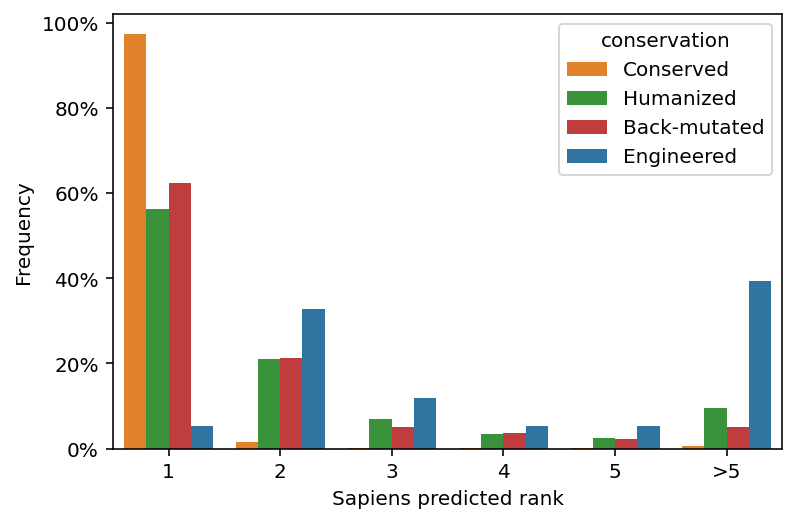

In [15]:
ax = sns.barplot(
    data=score_rank_freq,
    x='rank',
    y='freq',
    hue='conservation',
    order=['1','2','3','4','5','>5'],
    hue_order=['Conserved','Humanized','Back-mutated','Engineered'],
    palette=['tab:orange','tab:green','tab:red','tab:blue']
);
ax.set_ylabel('Frequency');
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['{:.0%}'.format(v) for v in ax.get_yticks()]);
ax.set_xlabel('Sapiens predicted rank');

# Preservation

In [16]:
def get_mean_conservation(positions, groupby, methods=None):
    conservation = positions.groupby(groupby)['conservation'].value_counts(normalize=True)
    conservation = conservation.unstack().fillna(0)
    conservation.columns.name = None
    return conservation

In [17]:
def conservation_barplot(conservation, rows=1, figsize=(12, 3), methods=None, axes=None):
    with sns.axes_style('whitegrid'):
        num_plots = conservation.index.get_level_values(0).nunique()
        cols = int(np.ceil(num_plots / rows))
        fig = None
        if axes is None:
            fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=True)
        for i, (title, values) in enumerate(conservation.groupby(level=0, sort=False)):
            values = values.reset_index().set_index('Method')
            assert values.index.is_unique, 'Expected one row for Method'
            if methods is not None:
                values = values.loc[methods]
            color = [COLORS[name] for name in values.index]
            ax = axes.flatten()[i]
            ax.bar(values.index, values['Conserved'], hatch='////', linewidth=0, color=color, alpha=0.8)
            ax.bar(values.index, values['Back-mutated'], linewidth=0, bottom=values['Conserved'], color=color)
            ax.set_xticks(values.index)
            ax.set_xticklabels(values.index, rotation=90)
            ax.set_title(title.replace(' ','\n'))
            #ax.set_xticks([])
            ax.set_ylim(0, 1.04)
            if i % cols == 0:
                ax.set_ylabel('Preservation');
            ax.set_yticks(np.arange(0, 1.01, 0.2))
            ax.set_yticklabels('{:.0%}'.format(v) for v in ax.get_yticks())
        if fig is not None:
            fig.tight_layout(h_pad=2);

In [18]:
pos_conservation = get_mean_conservation(
    positions, 
    groupby=['pos','Chain','Method']
)
pos_conservation.head()

Back-mutated  Conserved  Engineered  Humanized
pos Chain Method                                                      
H1  Heavy Experimental          0.00       0.60        0.00       0.40
          Hu-mAb                0.20       0.52        0.04       0.24
          Parental              0.40       0.60        0.00       0.00
          Sapiens*1             0.12       0.60        0.00       0.28
          Sapiens*2             0.00       0.60        0.00       0.40

In [19]:
experimental_preservation = pos_conservation[pos_conservation.index.get_level_values('Method') == EXPERIMENTAL['name']]
experimental_preservation = experimental_preservation.reset_index(level=2, drop=True)
heavy_experimental_preservation = experimental_preservation[experimental_preservation.index.get_level_values(1) == 'Heavy']
heavy_experimental_preservation = heavy_experimental_preservation.reset_index(level=1, drop=True)
light_experimental_preservation = experimental_preservation[experimental_preservation.index.get_level_values(1) == 'Light']
light_experimental_preservation = light_experimental_preservation.reset_index(level=1, drop=True)
heavy_experimental_preservation.head(2)

Back-mutated  Conserved  Engineered  Humanized
pos                                                
H1           0.00       0.60         0.0       0.40
H10          0.04       0.64         0.0       0.32

In [20]:
region_labels = positions['Chain'] + ' ' + positions['region']
region_conservation = get_mean_conservation(
    positions, 
    groupby=[region_labels,'Method']
).loc[region_labels.unique()]
region_conservation.head()

Back-mutated  Conserved  Engineered  Humanized
          Method                                                      
Heavy FR1 Experimental      0.060000   0.670667    0.008000   0.261333
          Hu-mAb            0.137517   0.695594    0.030708   0.136182
          Parental          0.232310   0.767690    0.000000   0.000000
          Sapiens*1         0.090667   0.765333    0.002667   0.141333
          Sapiens*2         0.064000   0.766667    0.002667   0.166667

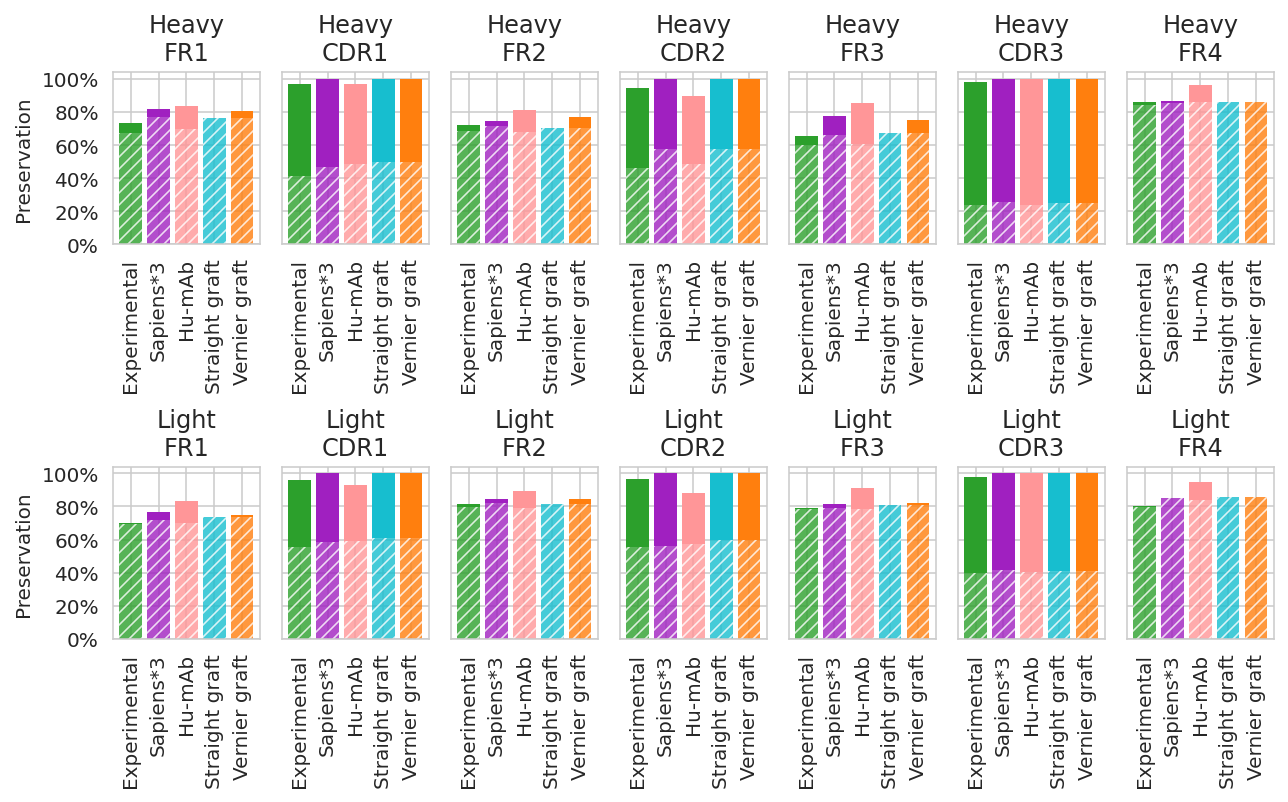

In [21]:
conservation_barplot(
    region_conservation, 
    rows=2, 
    methods=HUMANIZED_METHOD_NAMES,
    figsize=(9, 5.5)
)

In [22]:
vernier_positions = positions[positions['in_vernier']]

In [23]:
pos_labels = vernier_positions['region'] + ' ' + vernier_positions['pos']
vernier_conservation = get_mean_conservation(
    vernier_positions, 
    groupby=[pos_labels,'Chain','Method']
)
vernier_conservation.head()

Back-mutated  Conserved  Engineered  Humanized
       Chain Method                                                      
FR1 H2 Heavy Experimental      0.000000   0.800000    0.000000      0.200
             Hu-mAb            0.083333   0.750000    0.041667      0.125
             Parental          0.166667   0.833333    0.000000      0.000
             Sapiens*1         0.000000   0.800000    0.000000      0.200
             Sapiens*2         0.000000   0.800000    0.000000      0.200

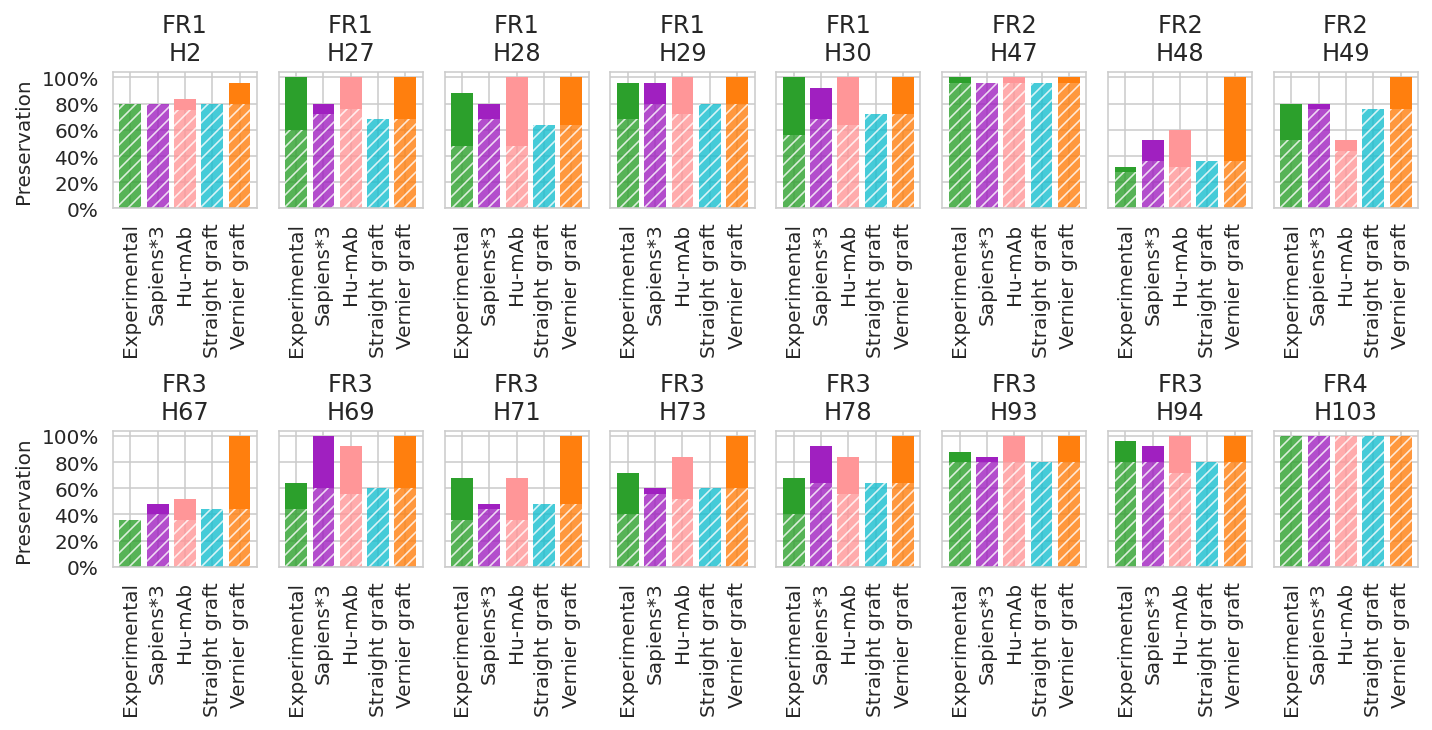

In [24]:
conservation_barplot(
    vernier_conservation[vernier_conservation.index.get_level_values('Chain') == 'Heavy'], 
    rows=2,
    methods=HUMANIZED_METHOD_NAMES,
    figsize=(10, 5)
)

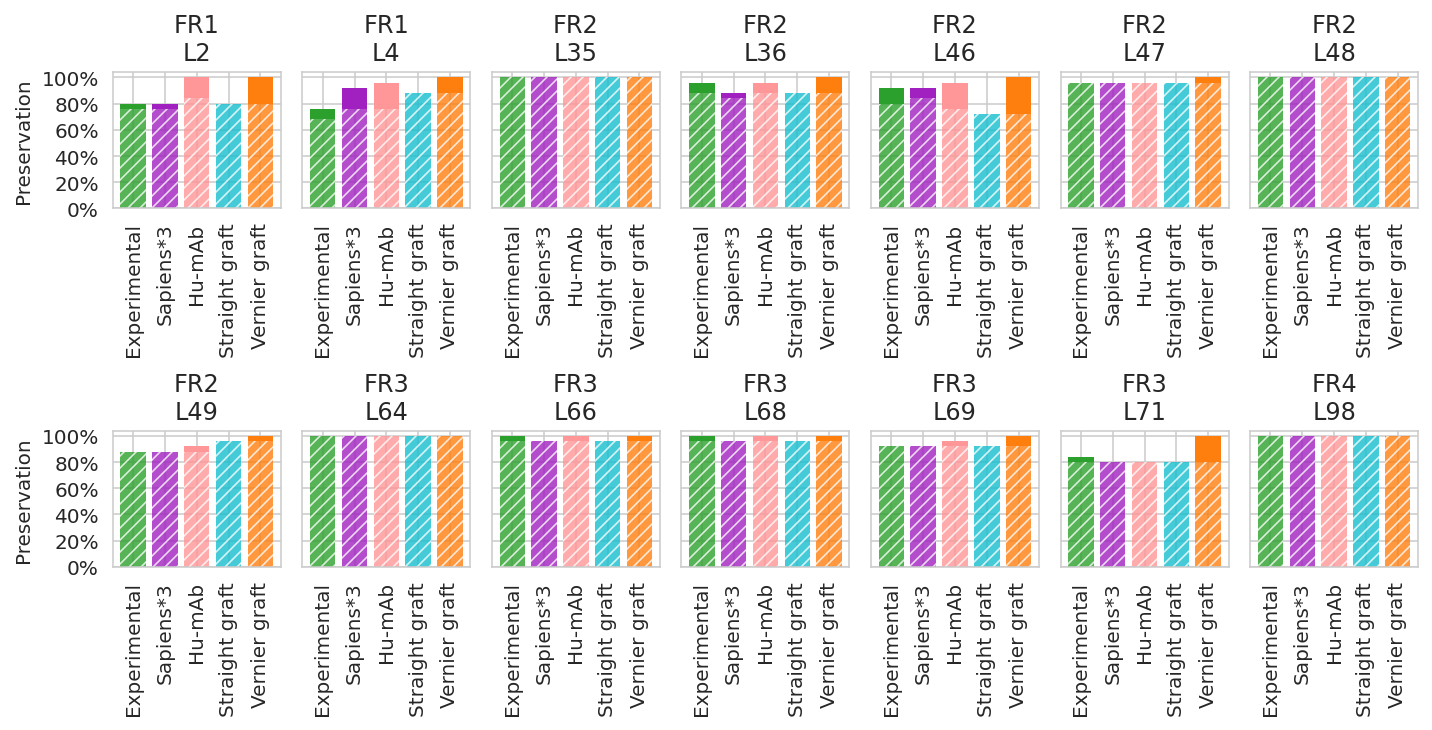

In [25]:
conservation_barplot(
    vernier_conservation[vernier_conservation.index.get_level_values('Chain') == 'Light'], 
    rows=2,
    methods=HUMANIZED_METHOD_NAMES,
    figsize=(10, 5)
)

In [26]:
import pandas
from pandas.plotting._matplotlib.core import MPLPlot

class PatchedMPLPlot(MPLPlot):
    def _plot(*args,**kwds):
        if "step" in kwds:            
            kwds["drawstyle"] = "steps-" + kwds["step"]
            kwds.pop("step")
        return MPLPlot._plot(*args, **kwds)

pandas.plotting._matplotlib.core.MPLPlot = PatchedMPLPlot

In [27]:
def plot_all_positions(positions, method, chain, color=None, ax=None):
    pos_conservation = get_mean_conservation(
        positions[positions['Method'] == method], 
        groupby=['Chain','pos','name']
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(27, 1.5))
    data = pos_conservation.loc[chain]
    mean = data[['Conserved', 'Back-mutated']].groupby('pos').mean().sum(axis=1)
    sorted_positions = sort_positions(mean.index, chain[0], 'kabat')
    position_objects = [Position.from_string(p, chain[0], 'kabat') for p in sorted_positions]
    position_labels = [('Vernier ' if p.is_in_vernier() else '') 
                       + (p.get_region()+' ' if p.is_in_cdr() else '') 
                       + p.format() for p in position_objects]
    mean.loc[sorted_positions].plot(ax=ax, color=color, lw=2, label=method, alpha=1)
    mean.loc[sorted_positions].plot.area(ax=ax, color=color, alpha=0.15, label='_nolegend_')
    ax.grid(False)
    ax.set_xticks(range(0, len(sorted_positions), 1));
    for i, p in enumerate(position_objects):
        if i % 2 == 1:
            ax.axvspan(i-0.5, i+0.5, color='black', alpha=0.03, zorder=-1)
        if p.is_in_vernier() or p.is_in_cdr():
            ax.axvspan(i-0.5, i+0.5, color='blue', alpha=0.07, zorder=-1)
    ax.set_xticklabels(position_labels, rotation=90);
    ax.set_xlim(0, len(sorted_positions)-1);
    ax.legend(loc='lower left', bbox_to_anchor=(0, 0), frameon=True);
    ax.set_ylabel('Preservation');
    ax.set_ylim(0, 1.02)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right();
    ax.text(-2, 0.5, f'{chain} chain', ha='center', va='center', rotation=90, fontsize=12)
    ax.set_xlabel('Kabat position')

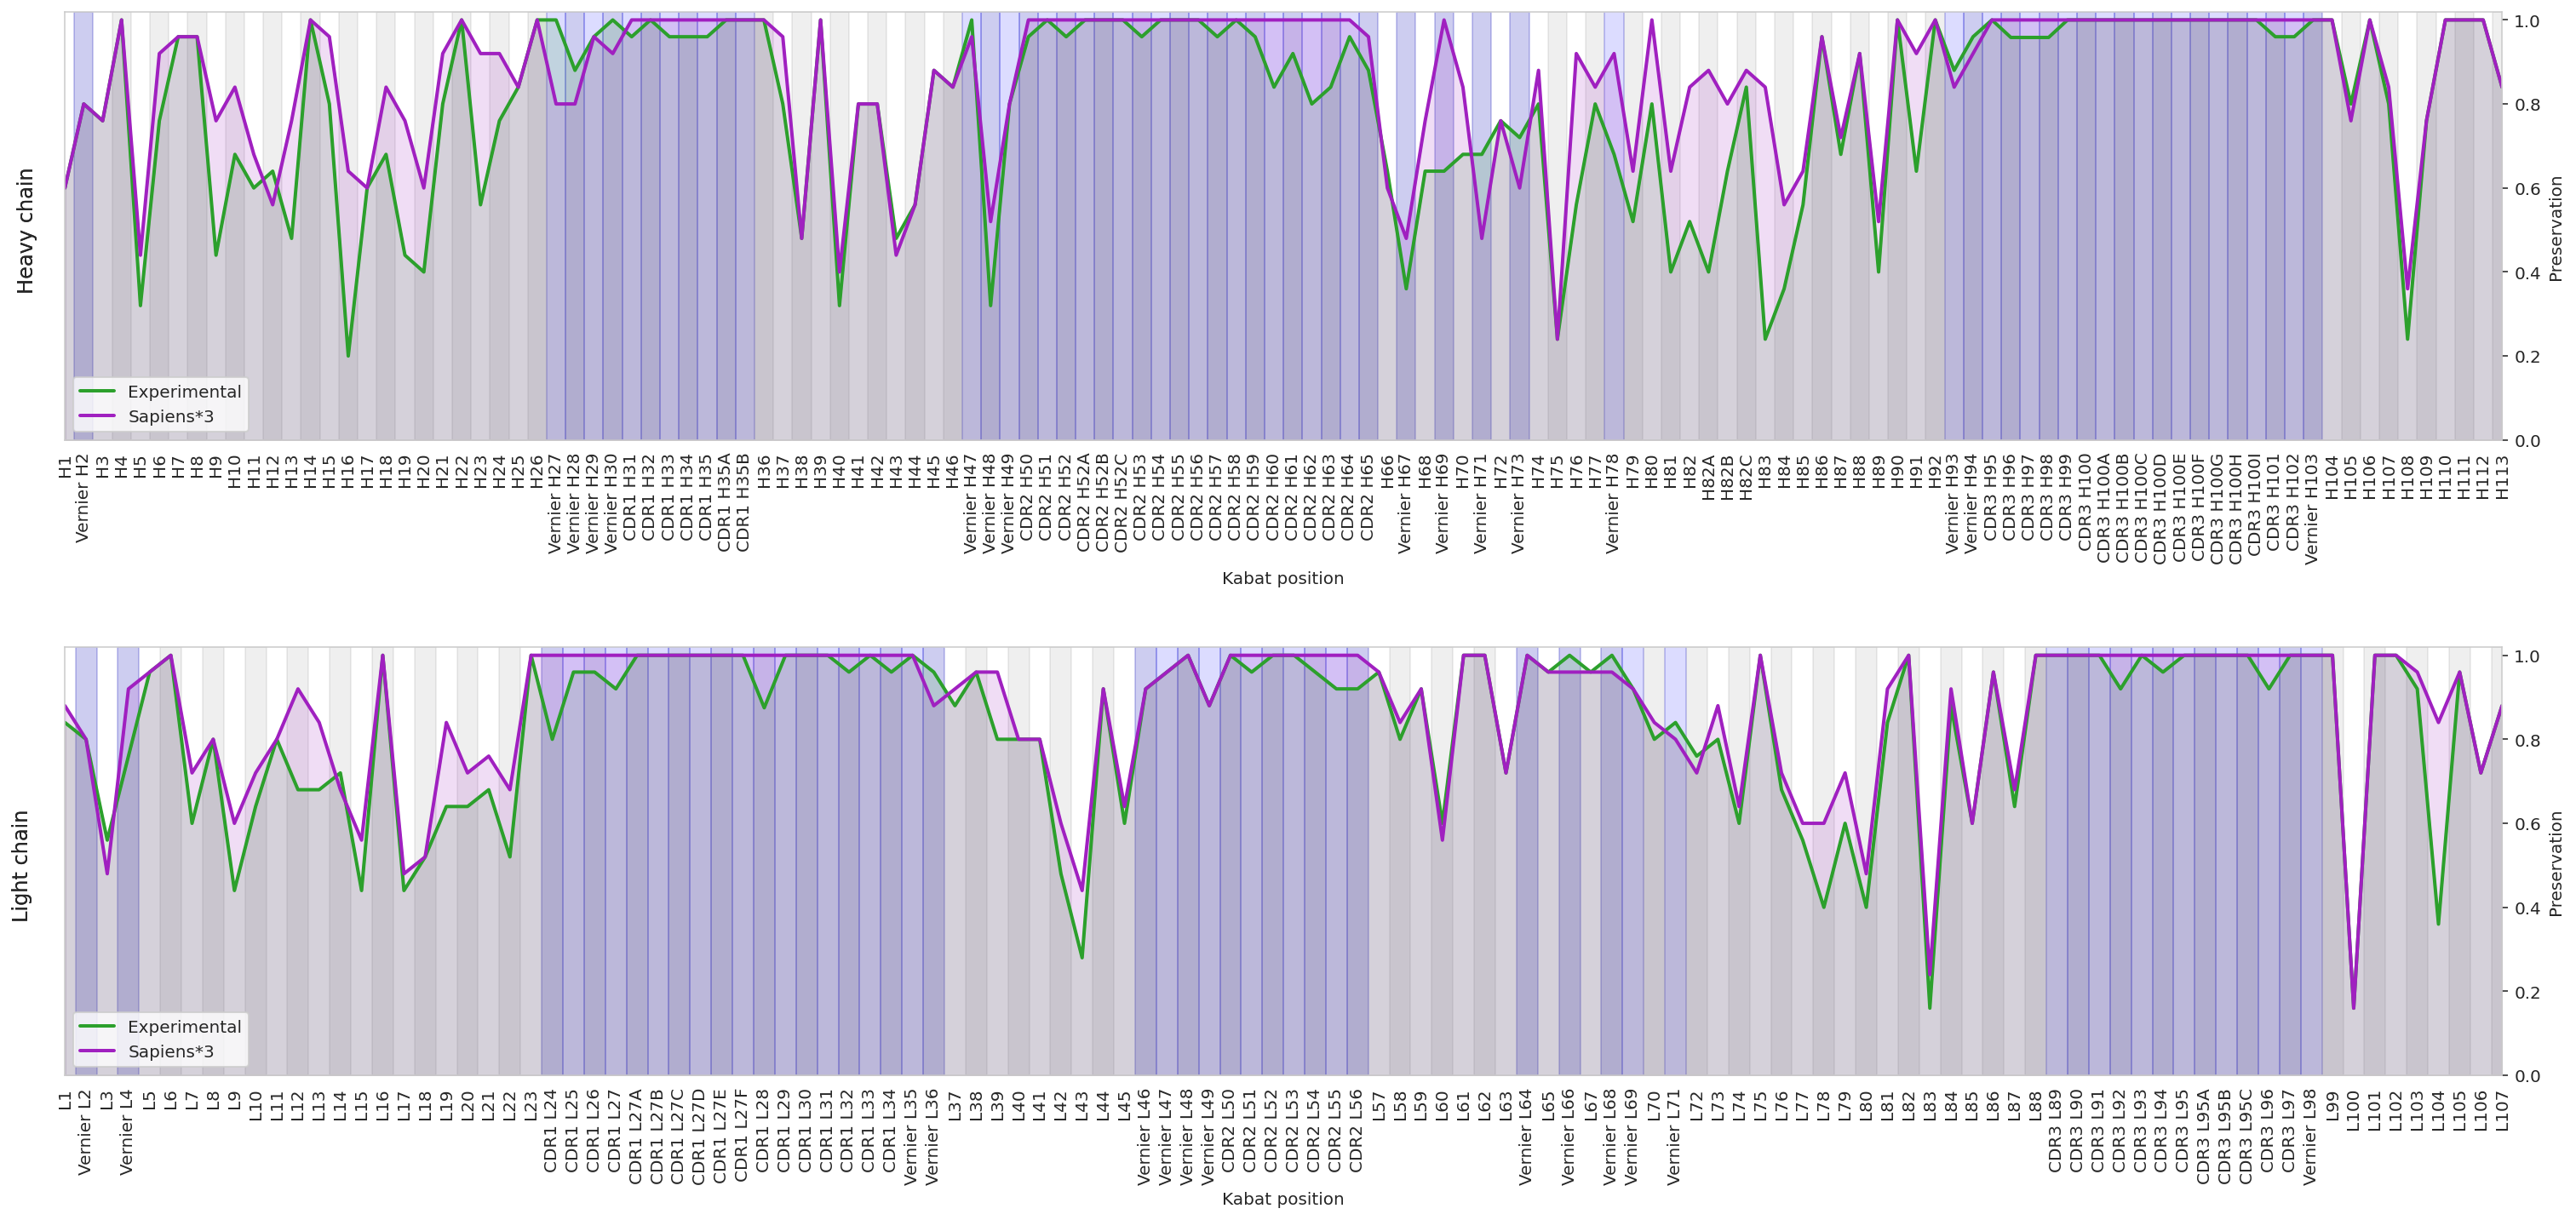

In [28]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(21, 10))

    plot_all_positions(positions, EXPERIMENTAL['name'], 'Heavy', color='tab:green', ax=axes[0])
    plot_all_positions(positions, SAPIENS['name'], 'Heavy', color=SAPIENS['color'], ax=axes[0])
    plot_all_positions(positions, EXPERIMENTAL['name'], 'Light', color='tab:green', ax=axes[1])
    plot_all_positions(positions, SAPIENS['name'], 'Light', color=SAPIENS['color'], ax=axes[1])
    fig.tight_layout(h_pad=4);

# Humanizing mutations overlap

In [29]:
baseline_residues = positions[positions['Method'] == EXPERIMENTAL['name']].set_index(['name','pos'])['predicted'].rename('baseline')
positions_with_baseline = positions.copy()
positions_with_baseline['baseline'] = positions_with_baseline[['name','pos']].apply(tuple, axis=1).apply(baseline_residues.to_dict().get)
positions_with_baseline.head()

Method  Chain      name pos  chain region  in_vernier parental predicted  \
0  Parental  Heavy  AntiCD28  H1  Heavy    FR1       False        E         E   
1  Parental  Heavy  AntiCD28  H2  Heavy    FR1        True        V         V   
2  Parental  Heavy  AntiCD28  H3  Heavy    FR1       False        K         K   
3  Parental  Heavy  AntiCD28  H4  Heavy    FR1       False        L         L   
4  Parental  Heavy  AntiCD28  H5  Heavy    FR1       False        Q         Q   

  germline  conservation baseline  
0        Q  Back-mutated        E  
1        V     Conserved        V  
2        Q  Back-mutated        Q  
3        L     Conserved        L  
4        Q     Conserved        V

In [30]:
accuracy = positions_with_baseline.groupby('Method').apply(lambda rows: (rows['predicted'] == rows['baseline']).mean())
accuracy.apply('{:.1%}'.format)

Method
Experimental      100.0%
Hu-mAb             86.2%
Parental           80.3%
Sapiens*1          87.9%
Sapiens*2          88.8%
Sapiens*3          88.7%
Sapiens*4          88.7%
Straight graft     88.2%
Vernier graft      88.5%
dtype: object

In [31]:
vernier_accuracy = positions_with_baseline[positions_with_baseline['in_vernier']].groupby('Method').apply(lambda rows: (rows['predicted'] == rows['baseline']).mean())
vernier_accuracy.apply('{:.1%}'.format)

Method
Experimental      100.0%
Hu-mAb             87.7%
Parental           85.8%
Sapiens*1          87.3%
Sapiens*2          86.5%
Sapiens*3          85.7%
Sapiens*4          85.6%
Straight graft     83.7%
Vernier graft      85.9%
dtype: object

In [32]:
mutations = positions_with_baseline.copy()
mutations = mutations[(mutations['parental'] != mutations['predicted']) | (mutations['parental'] != mutations['baseline'])]
mutations.head()

Method  Chain      name  pos  chain region  in_vernier parental  \
2   Parental  Heavy  AntiCD28   H3  Heavy    FR1       False        K   
4   Parental  Heavy  AntiCD28   H5  Heavy    FR1       False        Q   
8   Parental  Heavy  AntiCD28   H9  Heavy    FR1       False        P   
12  Parental  Heavy  AntiCD28  H13  Heavy    FR1       False        T   
14  Parental  Heavy  AntiCD28  H15  Heavy    FR1       False        S   

   predicted germline  conservation baseline  
2          K        Q  Back-mutated        Q  
4          Q        Q     Conserved        V  
8          P        P     Conserved        G  
12         T        K  Back-mutated        Q  
14         S        S     Conserved        G

In [33]:
def get_mutation_overlap(positions):
    agreeing = positions['predicted'] == positions['baseline']
    return pd.Series({
        'Baseline only': (~agreeing & (positions['parental'] != positions['baseline'])).sum(),
        'Shared': agreeing.sum(),
        'Predicted only': (~agreeing & (positions['parental'] != positions['predicted'])).sum(),
    })

In [34]:
overlap = mutations.groupby(['Method','name']).apply(get_mutation_overlap)
overlap.head()

Baseline only  Shared  Predicted only
Method       name                                               
Experimental AntiCD28                  0      54               0
             Bevacizumab               0      41               0
             Campath                   0      53               0
             Certolizumab              0      51               0
             Clazakizumab              0      49               0

In [35]:
vernier_overlap = mutations[mutations['in_vernier']].groupby(['Method','name']).apply(get_mutation_overlap)
vernier_overlap.head()

Baseline only  Shared  Predicted only
Method       name                                               
Experimental AntiCD28                  0       9               0
             Bevacizumab               0       3               0
             Campath                   0       6               0
             Certolizumab              0       1               0
             Clazakizumab              0       6               0

In [36]:
mean_overlap = overlap.groupby(level=0).mean()
mean_overlap

Baseline only  Shared  Predicted only
Method                                               
Experimental             0.00   45.20            0.00
Hu-mAb                  26.96   18.12            7.20
Parental                45.08    0.00            0.00
Sapiens*1               24.88   20.28            6.16
Sapiens*2               22.00   23.20            8.04
Sapiens*3               21.40   23.80            8.92
Sapiens*4               21.32   23.88            9.16
Straight graft          19.52   25.68           13.96
Vernier graft           21.60   23.60           10.00

In [37]:
precision = mean_overlap['Shared'] / mean_overlap[['Shared','Predicted only']].sum(axis=1)
precision.apply('{:.1%}'.format)

Method
Experimental      100.0%
Hu-mAb             71.6%
Parental            nan%
Sapiens*1          76.7%
Sapiens*2          74.3%
Sapiens*3          72.7%
Sapiens*4          72.3%
Straight graft     64.8%
Vernier graft      70.2%
dtype: object

In [38]:
mean_vernier_overlap = vernier_overlap.groupby(level=0).mean()
mean_vernier_overlap

Baseline only    Shared  Predicted only
Method                                                 
Experimental         0.000000  4.652174        0.000000
Hu-mAb               2.875000  1.541667        1.291667
Parental             4.608696  0.000000        0.000000
Sapiens*1            2.760000  1.520000        1.560000
Sapiens*2            2.600000  1.680000        2.280000
Sapiens*3            2.600000  1.680000        2.520000
Sapiens*4            2.600000  1.680000        2.560000
Straight graft       2.160000  2.120000        3.960000
Vernier graft        4.608696  0.043478        0.000000

In [39]:
vernier_precision = mean_vernier_overlap['Shared'] / mean_vernier_overlap[['Shared','Predicted only']].sum(axis=1)
vernier_precision.apply('{:.1%}'.format)

Method
Experimental      100.0%
Hu-mAb             54.4%
Parental            nan%
Sapiens*1          49.4%
Sapiens*2          42.4%
Sapiens*3          40.0%
Sapiens*4          39.6%
Straight graft     34.9%
Vernier graft     100.0%
dtype: object

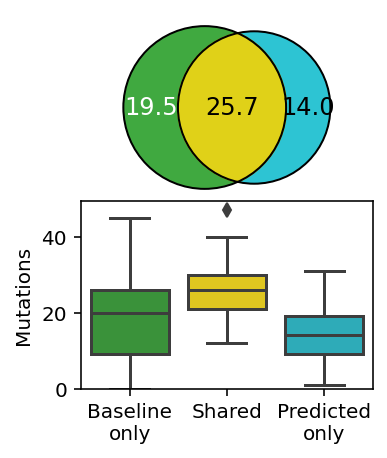

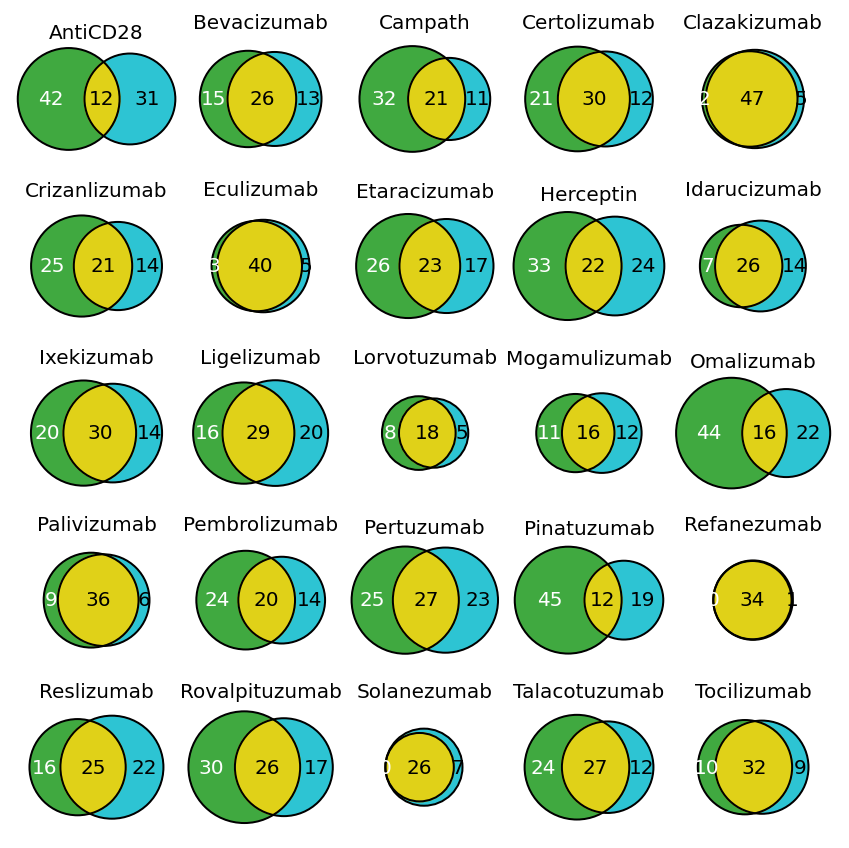

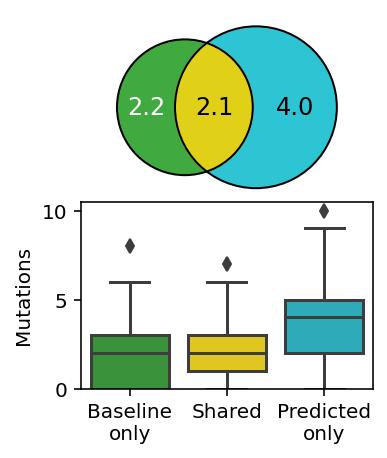

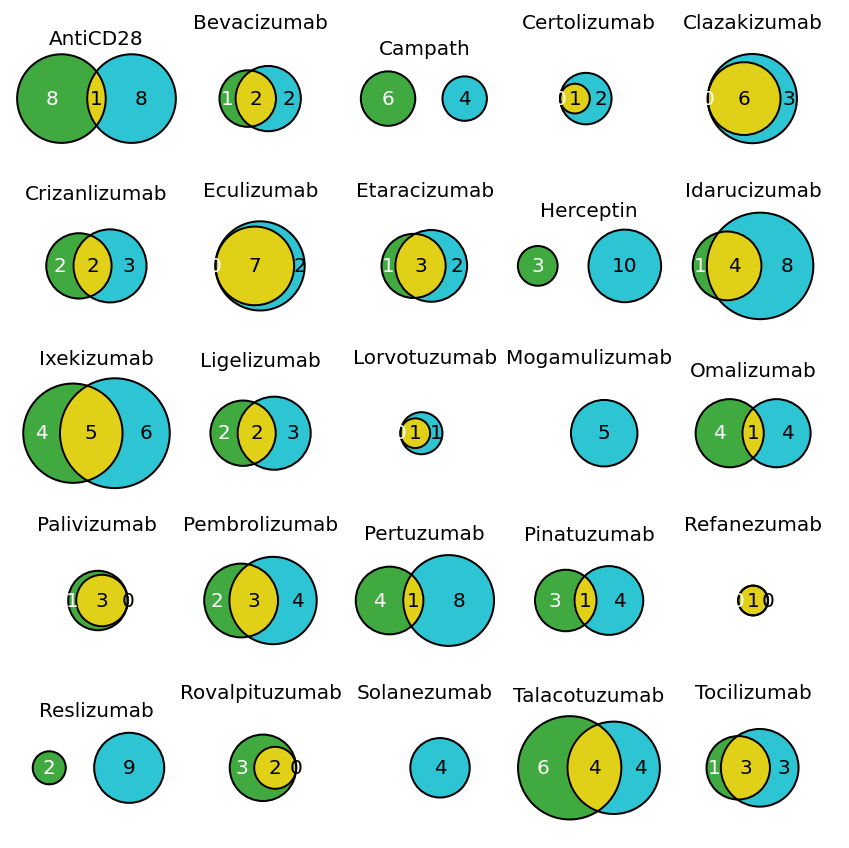

In [40]:
name = STRAIGHT_GRAFT['name']
colors = {
    'Baseline': COLORS['Experimental'],
    'Prediction': COLORS[name]
}
heading('Total overlap')
plot_overlap(overlap.loc[name], colors=colors, predicted_label_color='black')
plt.show()
plot_overlap_venns(overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6), predicted_label_color='black')
plt.show()
heading('Vernier overlap')
plot_overlap(vernier_overlap.loc[name], colors=colors, predicted_label_color='black')
plt.show()
plot_overlap_venns(vernier_overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6), predicted_label_color='black')
plt.show()

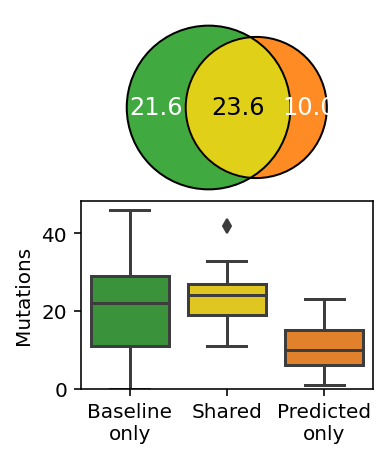

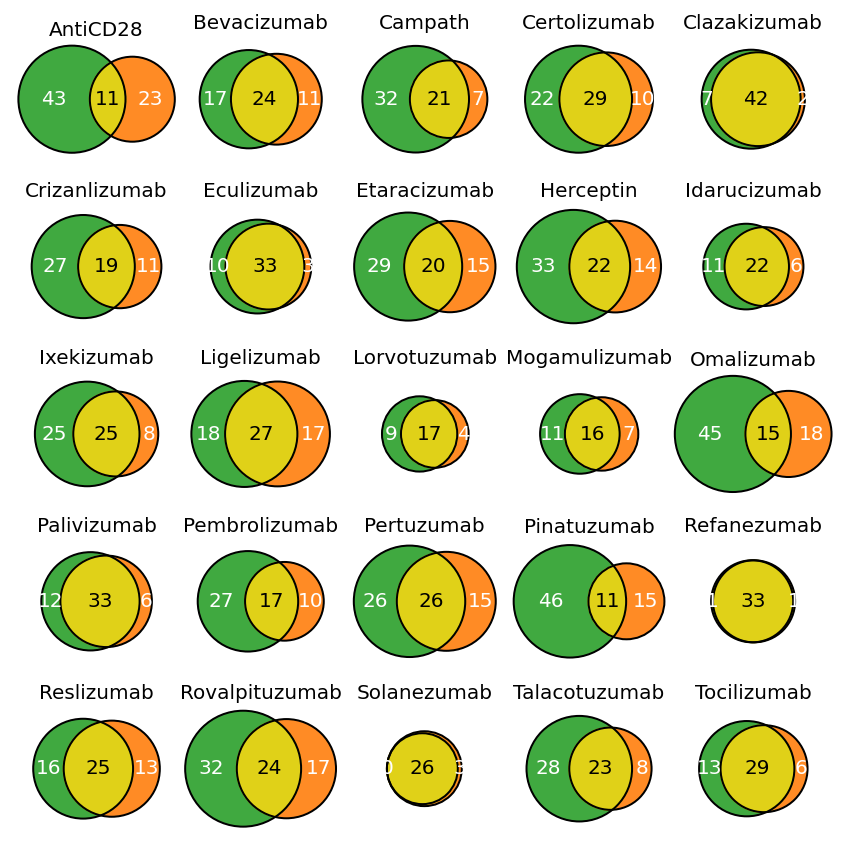

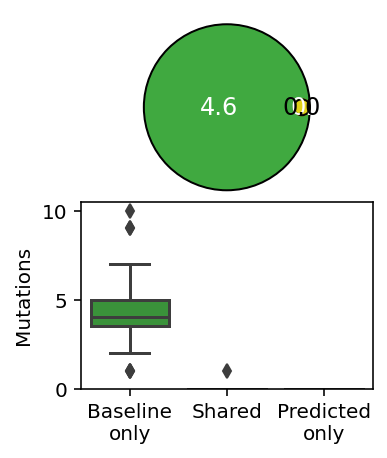

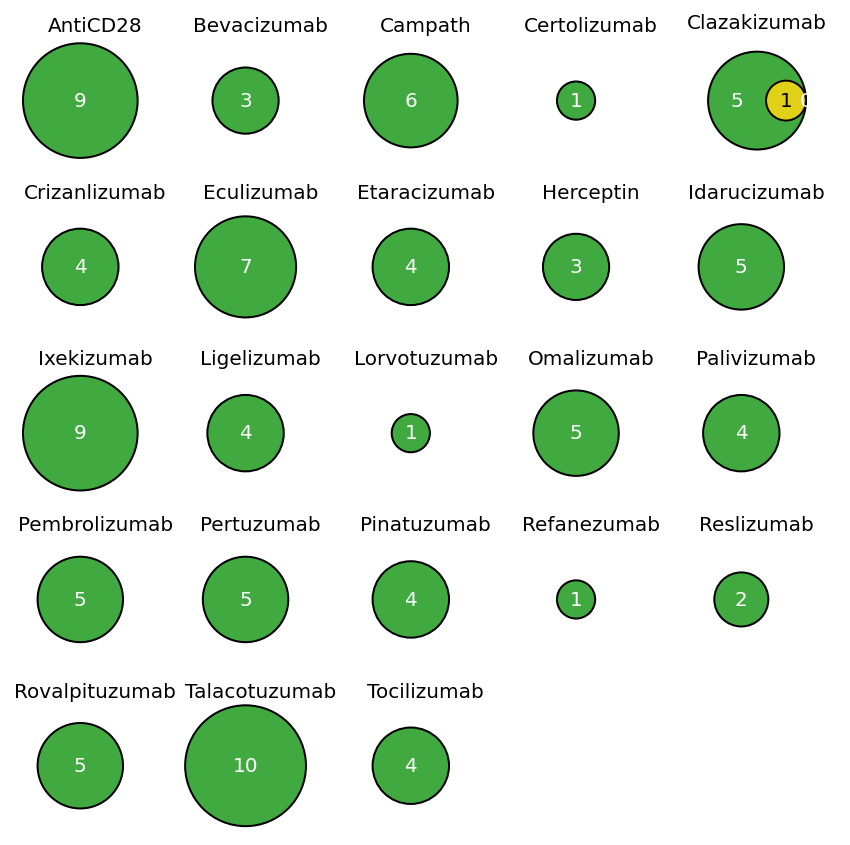

In [41]:
name = VERNIER_GRAFT['name']
colors = {
    'Baseline': COLORS['Experimental'],
    'Prediction': COLORS[name]
}
heading('Total overlap')
plot_overlap(overlap.loc[name], colors=colors)
plt.show()
plot_overlap_venns(overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6))
plt.show()
heading('Vernier overlap')
plot_overlap(vernier_overlap.loc[name], colors=colors)
plt.show()
plot_overlap_venns(vernier_overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6))
plt.show()

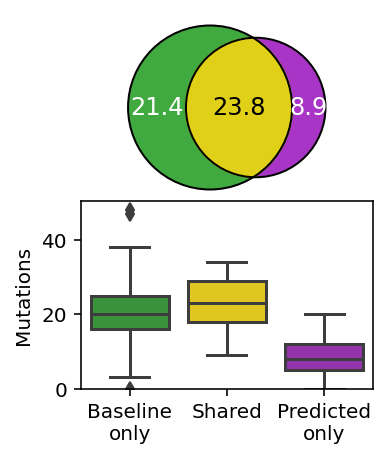

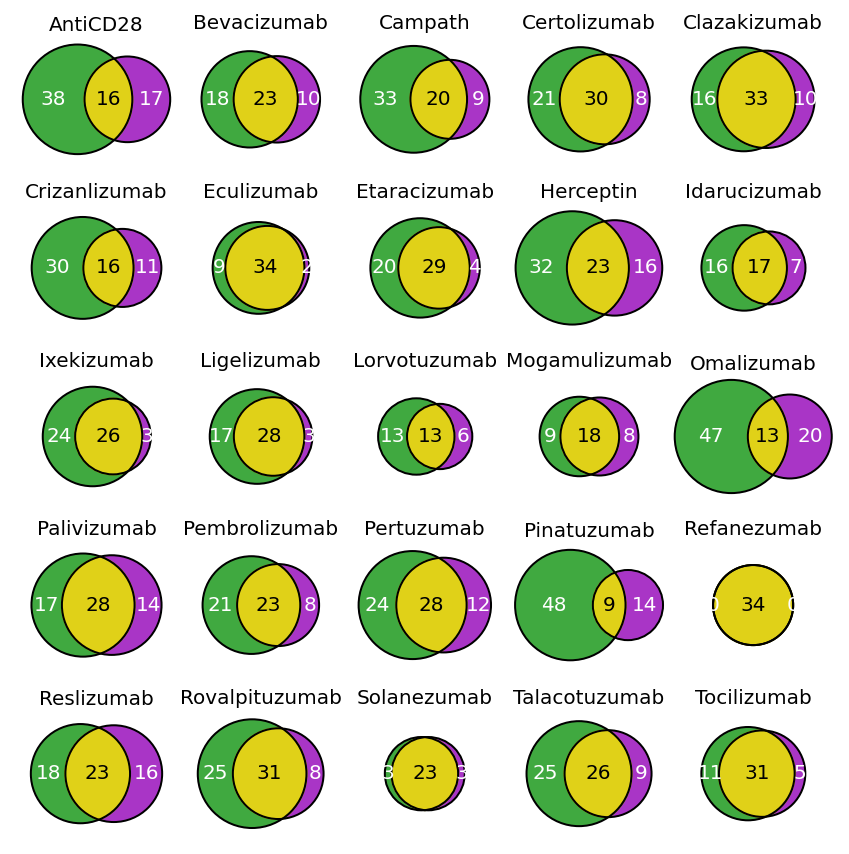

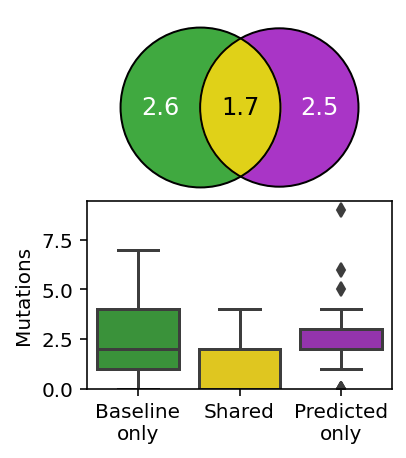

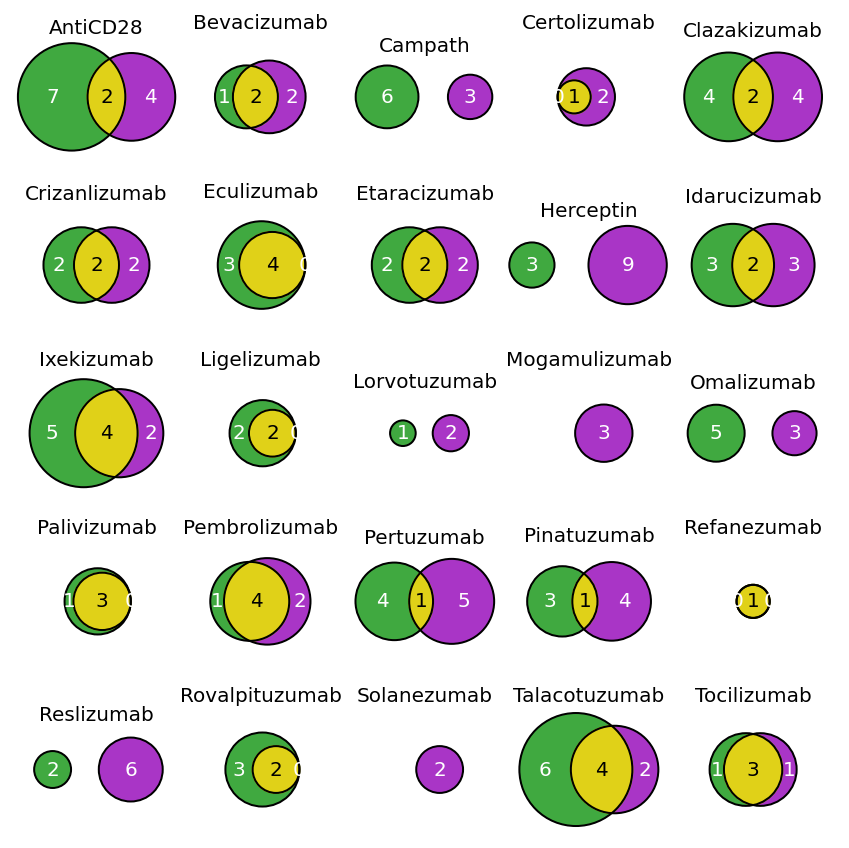

In [42]:
name = SAPIENS['name']
colors = {
    'Baseline': COLORS['Experimental'],
    'Prediction': COLORS[name]
}
heading('Total overlap')
plot_overlap(overlap.loc[name], colors=colors)
plt.show()
plot_overlap_venns(overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6))
plt.show()
heading('Vernier overlap')
plot_overlap(vernier_overlap.loc[name], colors=colors)
plt.show()
plot_overlap_venns(vernier_overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6))
plt.show()

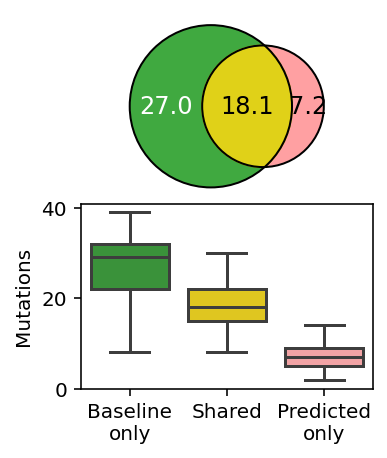

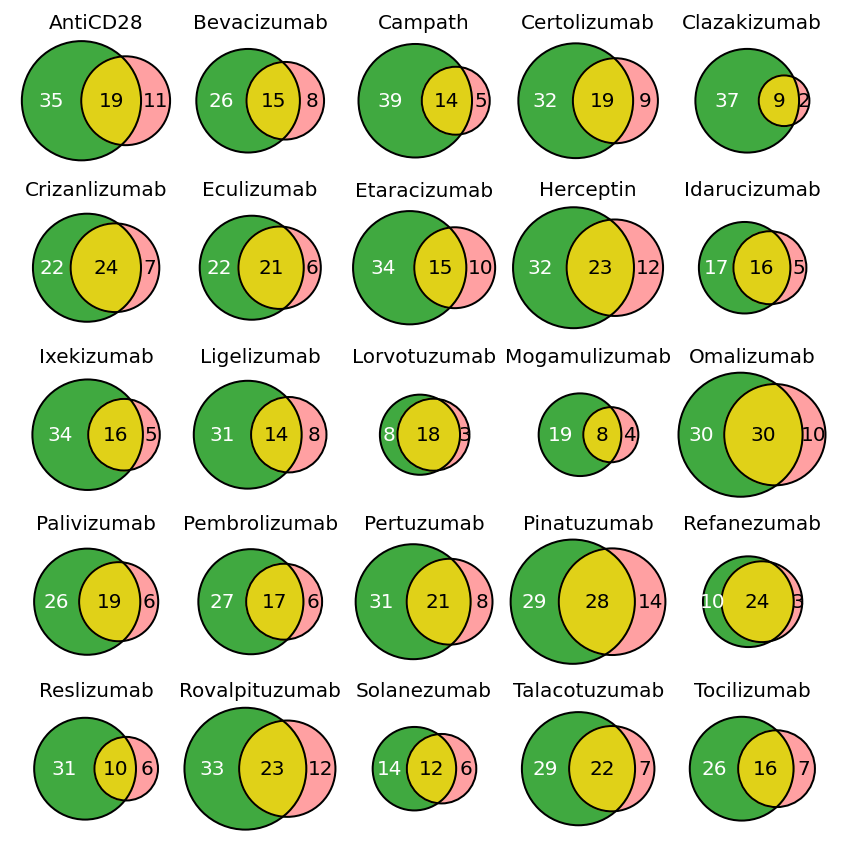

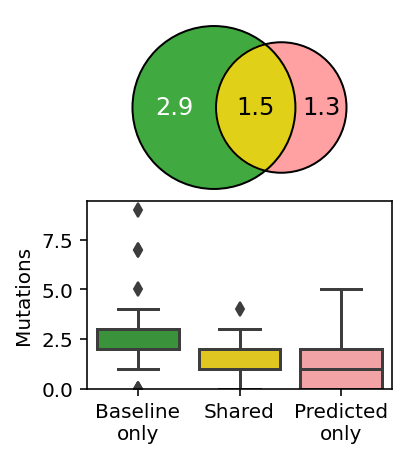

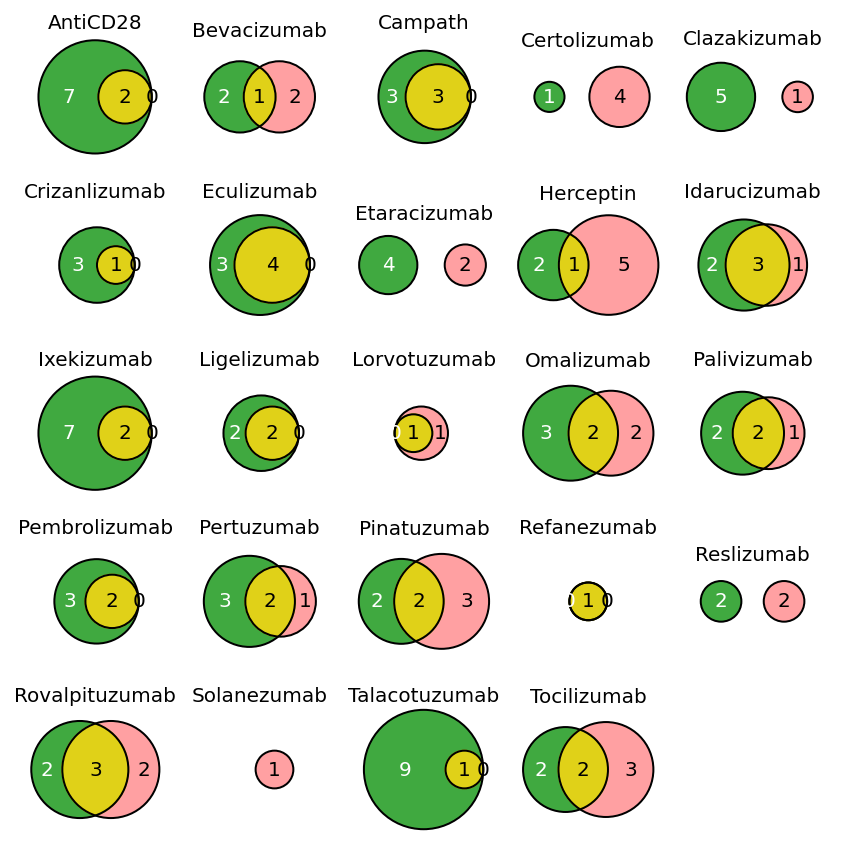

In [43]:
name = HUMAB['name']
colors = {
    'Baseline': COLORS['Experimental'],
    'Prediction': COLORS[name]
}
heading('Total overlap')
plot_overlap(overlap.loc[name], colors=colors, predicted_label_color='black')
plt.show()
plot_overlap_venns(overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6), predicted_label_color='black')
plt.show()
heading('Vernier overlap')
plot_overlap(vernier_overlap.loc[name], colors=colors, predicted_label_color='black')
plt.show()
plot_overlap_venns(vernier_overlap.loc[name], colors=colors, rows=5, cols=5, figsize=(6, 6), predicted_label_color='black')
plt.show()

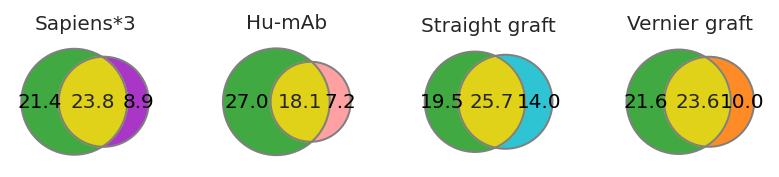

In [44]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 4, figsize=(5.5, 2.5))
    for i, name in enumerate([SAPIENS['name'], HUMAB['name'], STRAIGHT_GRAFT['name'], VERNIER_GRAFT['name']]):
        colors = {
            'Baseline': COLORS['Experimental'],
            'Prediction': COLORS[name]
        }
        plot_overlap_venn(overlap.loc[name].mean(), colors=colors, fontsize=10, outline='grey',
                          baseline_label_color='black', predicted_label_color='black', ax=axes[i])
        axes[i].set_title(name, fontsize=10)
    fig.tight_layout(w_pad=3);
    fig.savefig('../../data/figures/main/fig5d.pdf', bbox_inches='tight')

In [45]:
def get_conservation_flags(positions):
    positions = positions.set_index('Method', verify_integrity=True)
    return (positions['parental'] == positions['germline']).reindex(HUMANIZED_METHOD_NAMES, fill_value=False)

def get_mutated_flags(positions):
    positions = positions.set_index('Method', verify_integrity=True)
    return (positions['parental'] != positions['predicted']).reindex(HUMANIZED_METHOD_NAMES, fill_value=False)

In [46]:
vernier_conserved_flags = vernier_positions.groupby(['name','pos']).apply(get_conservation_flags)
vernier_conserved_flags.head()

Method         Experimental  Sapiens*3  Hu-mAb  Straight graft  Vernier graft
name     pos                                                                 
AntiCD28 H103          True       True    True            True           True
         H2            True       True    True            True           True
         H27           True      False    True           False          False
         H28          False       True   False            True           True
         H29          False      False   False           False          False

In [47]:
vernier_mutated_flags = vernier_positions.groupby(['name','pos']).apply(get_mutated_flags)
vernier_mutated_flags.head()

Method         Experimental  Sapiens*3  Hu-mAb  Straight graft  Vernier graft
name     pos                                                                 
AntiCD28 H103         False      False   False           False          False
         H2           False      False   False           False          False
         H27          False       True   False            True          False
         H28           True      False   False           False          False
         H29           True      False   False            True          False

In [48]:
def get_contingency_matrix(mutated_flags, conserved_flags, names):
    # select only positions that are not conserved between parent and human germline (in both the first and second sequence)
    mutated_flags = mutated_flags[~conserved_flags[names[0]] & ~conserved_flags[names[1]]]

    first = mutated_flags[names[0]]
    second = mutated_flags[names[1]]
    mutated_both = (first & second).sum()
    mutated_first_only = (first & ~second).sum()
    mutated_second_only = (~first & second).sum()
    mutated_none = (~first & ~second).sum()
    
    contingency = [
        [mutated_both, mutated_second_only],
        [mutated_first_only, mutated_none]
    ]
    return pd.DataFrame(
        contingency, 
        index=[f'Humanized {names[1]}', f'Back-mutated {names[1]}'], 
        columns=[f'Humanized {names[0]}', f'Back-mutated {names[0]}']
    )

In [49]:
def fisher_stats(names):
    heading(' & '.join(names))
    contingency = get_contingency_matrix(
        mutated_flags=vernier_mutated_flags, 
        conserved_flags=vernier_conserved_flags, 
        names=names
    )
    print('p-value:', stats.fisher_exact(contingency, alternative='greater')[1])
    print('Total positions', contingency.sum().sum())
    display(contingency)
    display(contingency / contingency.sum().sum())
    print('TPR = {:.0%}'.format(contingency.iloc[0,0] / contingency.sum()[0]))
    print('FPR = {:.0%}'.format(contingency.iloc[0,1] / contingency.sum()[1]))

# Binary overlap of mutated Vernier positions

**NOTE:** Only positions that are not conserved in either of the two methods were considered to avoid overinflating the true negatives.

In [50]:
for name in HUMANIZED_METHOD_NAMES:
    fisher_stats([EXPERIMENTAL['name'], name])

p-value: 4.752360247654652e-58
Total positions 195


Humanized Experimental  Back-mutated Experimental
Humanized Experimental                        103                          0
Back-mutated Experimental                       0                         92

Humanized Experimental  Back-mutated Experimental
Humanized Experimental                   0.528205                   0.000000
Back-mutated Experimental                0.000000                   0.471795

TPR = 100%
FPR = 0%


p-value: 0.08829289734797657
Total positions 139


Humanized Experimental  Back-mutated Experimental
Humanized Sapiens*3                         63                         30
Back-mutated Sapiens*3                      25                         21

Humanized Experimental  Back-mutated Experimental
Humanized Sapiens*3                   0.453237                   0.215827
Back-mutated Sapiens*3                0.179856                   0.151079

TPR = 72%
FPR = 59%


p-value: 0.00022809227810510622
Total positions 163


Humanized Experimental  Back-mutated Experimental
Humanized Hu-mAb                         45                         12
Back-mutated Hu-mAb                      53                         53

Humanized Experimental  Back-mutated Experimental
Humanized Hu-mAb                   0.276074                   0.073620
Back-mutated Hu-mAb                0.325153                   0.325153

TPR = 46%
FPR = 18%


p-value: 1.0
Total positions 133


Humanized Experimental  Back-mutated Experimental
Humanized Straight graft                         83                         50
Back-mutated Straight graft                       0                          0

Humanized Experimental  Back-mutated Experimental
Humanized Straight graft                    0.62406                    0.37594
Back-mutated Straight graft                 0.00000                    0.00000

TPR = 100%
FPR = 100%


p-value: 0.624060150375934
Total positions 133


Humanized Experimental  Back-mutated Experimental
Humanized Vernier graft                          1                          0
Back-mutated Vernier graft                      82                         50

Humanized Experimental  Back-mutated Experimental
Humanized Vernier graft                   0.007519                    0.00000
Back-mutated Vernier graft                0.616541                    0.37594

TPR = 1%
FPR = 0%


# OASis Humanness

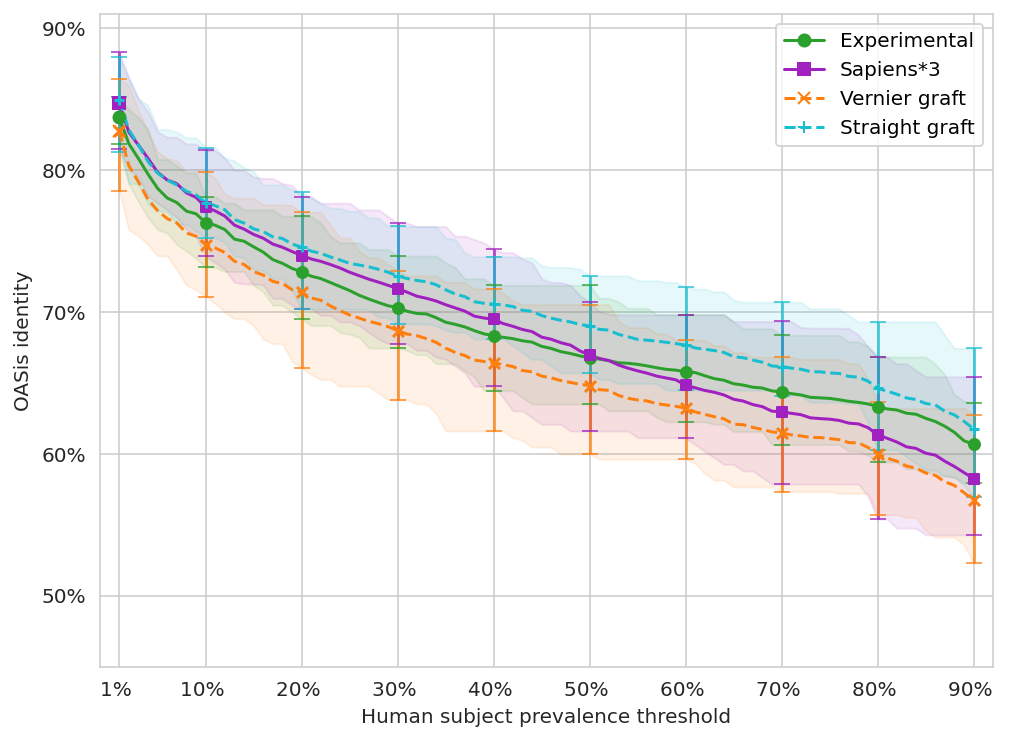

In [51]:
colors = {n: c for n, c in COLORS.items() if n in [EXPERIMENTAL['name'], SAPIENS['name'], VERNIER_GRAFT['name'], STRAIGHT_GRAFT['name']]}
plot_oasis_curves(oasis_curves, groupby='Method', errorbars=True, colors=colors, thresholds=False, linestyles=LINESTYLES, figsize=(8, 6))
ax = plt.gca()
ax.set_ylim(0.45, 0.91);
ax.legend();

# T20 Humanness

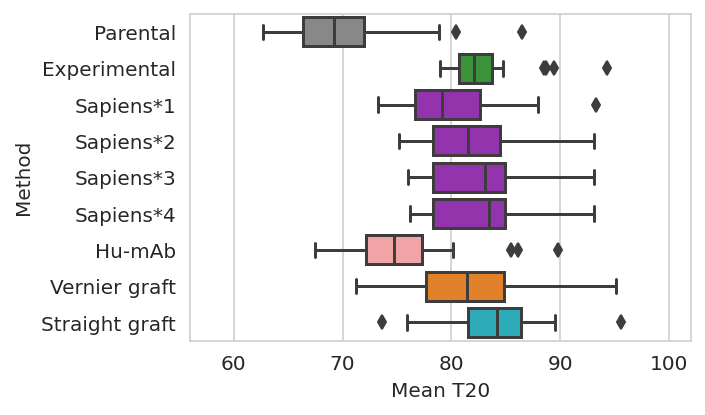

In [52]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.boxplot(
        data=t20_scores, 
        x='t20', 
        y='Method',
        hue_order=COLORS.keys(),
        palette=COLORS.values(),
        ax=ax
    );
    ax.set_xlabel(f'Mean T20')
    ax.set_xticks(range(50, 101, 10))
    ax.set_xlim([56, 102])
fig.tight_layout();

In [53]:
t20_scores.groupby('Method')['t20'].mean().apply('{:.1f}%'.format)

Method
Experimental      83.1%
Hu-mAb            75.6%
Parental          70.0%
Sapiens*1         80.2%
Sapiens*2         81.8%
Sapiens*3         82.4%
Sapiens*4         82.5%
Straight graft    83.8%
Vernier graft     81.4%
Name: t20, dtype: object

In [54]:
t20_heatmap = t20_scores.pivot_table(index='Method', columns='Antibody', values='t20')
t20_heatmap = t20_heatmap.loc[COLORS]
t20_heatmap

Antibody         AntiCD28  Bevacizumab    Campath  Certolizumab  Clazakizumab  \
Method                                                                          
Parental        62.653985    71.813920  71.951535     69.563870     64.534170   
Experimental    80.728035    81.455470  78.961085     83.621170     80.719770   
Sapiens*1       74.748620    83.337770  82.597020     81.988220     73.229870   
Sapiens*2       75.186120    84.483920  83.766770     85.403285     76.140385   
Sapiens*3       75.980235    84.483920  83.766770     85.777085     76.649685   
Sapiens*4       76.394420    84.483920  83.766770     85.777085     76.649685   
Hu-mAb          69.668220    73.442420  70.358070     70.602770     67.454620   
Vernier graft   72.529870    84.617785  82.808470     85.013920     79.124185   
Straight graft  75.886970    86.408770  83.552270     86.305270     82.228385   

Antibody        Crizanlizumab  Eculizumab  Etaracizumab  Herceptin  \
Method                                                               
Parental            67.682735    64.19782      71.50357  67.559820   
Experimental        82.505535    81.79187      83.55187  88.664935   
Sapiens*1           75.924770    75.43327      80.97117  79.138670   
Sapiens*2           77.605120    78.34177      83.50077  81.504320   
Sapiens*3           77.605120    78.34177      84.90262  83.066820   
Sapiens*4           77.605120    78.34177      84.90262  84.650435   
Hu-mAb              77.341320    74.73562      80.15667  74.395120   
Vernier graft       75.376120    77.65267      77.26722  81.391820   
Straight graft      76.953970    81.49137      79.01857  85.516270   

Antibody        Idarucizumab  ...  Palivizumab  Pembrolizumab  Pertuzumab  \
Method                        ...                                           
Parental           68.611020  ...    65.871185      66.297370   66.433920   
Experimental       81.949370  ...    80.061085      79.228070   83.141920   
Sapiens*1          75.859620  ...    76.643770      78.134885   78.349820   
Sapiens*2          77.006635  ...    79.526670      77.504285   81.398800   
Sapiens*3          77.396520  ...    81.380870      77.504285   83.106635   
Sapiens*4          77.396520  ...    82.235320      77.504285   83.547570   
Hu-mAb             75.984770  ...    75.293070      74.774270   72.156870   
Vernier graft      78.999970  ...    79.935470      73.815085   81.382720   
Straight graft     83.878785  ...    81.834220      76.815085   84.179570   

Antibody        Pinatuzumab  Refanezumab  Reslizumab  Rovalpituzumab  \
Method                                                                 
Parental          71.922720    80.436685   66.350570       69.221320   
Experimental      79.613170    89.424785   81.157420       83.986470   
Sapiens*1         78.261970    87.956800   80.038370       80.767685   
Sapiens*2         79.470270    88.670835   82.760585       82.250570   
Sapiens*3         80.136085    89.424785   84.053685       83.092670   
Sapiens*4         80.136085    89.424785   84.635585       83.474070   
Hu-mAb            70.022635    86.131135   70.365085       73.582720   
Vernier graft     80.779870    89.087485   83.636070       85.449370   
Straight graft    83.529870    89.484335   87.566635       86.254470   

Antibody        Solanezumab  Talacotuzumab  Tocilizumab  
Method                                                   
Parental          86.524770      72.001435    72.464770  
Experimental      94.243785      83.696820    84.707985  
Sapiens*1         93.239335      84.160070    85.474820  
Sapiens*2         93.060735      86.313385    87.688920  
Sapiens*3         93.060735      86.313385    88.062770  
Sapiens*4         93.060735      86.313385    88.062770  
Hu-mAb            89.761420      77.219135    79.900185  
Vernier graft     95.136635      84.850435    86.750470  
Straight graft    95.583085      88.081770    89.512370  

[9 rows x 25 columns]

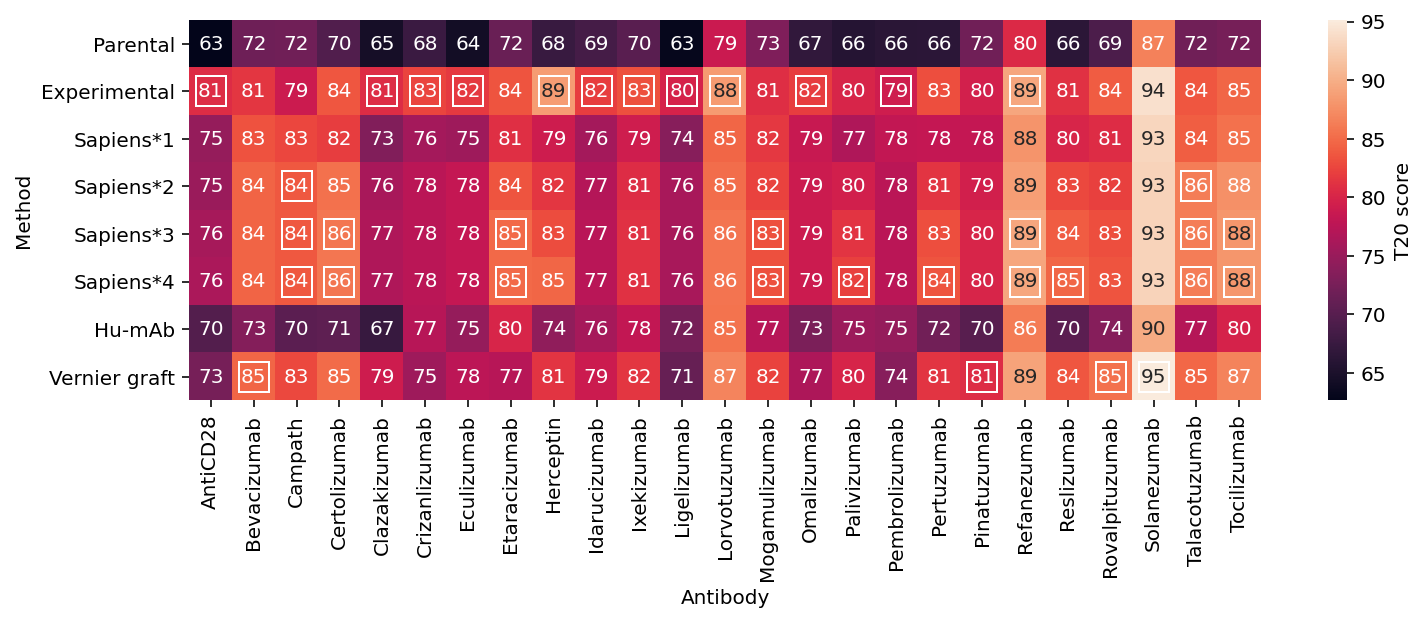

In [55]:
fig, ax = plt.subplots(figsize=(12, 3.5))

df = t20_heatmap.drop([STRAIGHT_GRAFT['name']])
best_mask = df.apply(pd.Series.rank, method='max') == len(df)
sns.heatmap(df, annot=True, ax=ax, cbar_kws=dict(label='T20 score'));

for i in range(len(df)):
    for j in range(len(df.columns)):
        if best_mask.iloc[i, j]:
            ax.plot(j+0.5, i+0.5, marker='s', markeredgecolor='white', markersize=15, color=(0,0,0,0))

In [56]:
humab_scores = pd.read_excel(os.path.join(TASK_DIR, 'pairs/humab_results.xlsx'), index_col=0)
humab_scores.head()

V Gene  Initial Score  Target Score  # Exp. Mutations  \
Therapeutic                                                         
AntiCD28       kv4          0.050         0.805                19   
Campath        kv1          0.724         0.842                14   
Bevacizumab    kv1          0.017         0.899                16   
Herceptin      kv1          0.032         0.776                22   
Omalizumab     kv1          0.081         0.874                25   

             # Hu-mAb Mutations  Mutation Ratio  Overlap Ratio  Adjusted OR  
Therapeutic                                                                  
AntiCD28                     11            0.58           0.64         0.73  
Campath                       3            0.21           0.67         0.67  
Bevacizumab                   9            0.56           0.89         1.00  
Herceptin                     8            0.36           0.88         0.88  
Omalizumab                   19            0.76           0.89         0.95

T20 83.1075714 75.5885356
OASis 0.6677734947712411 0.4710268916862178


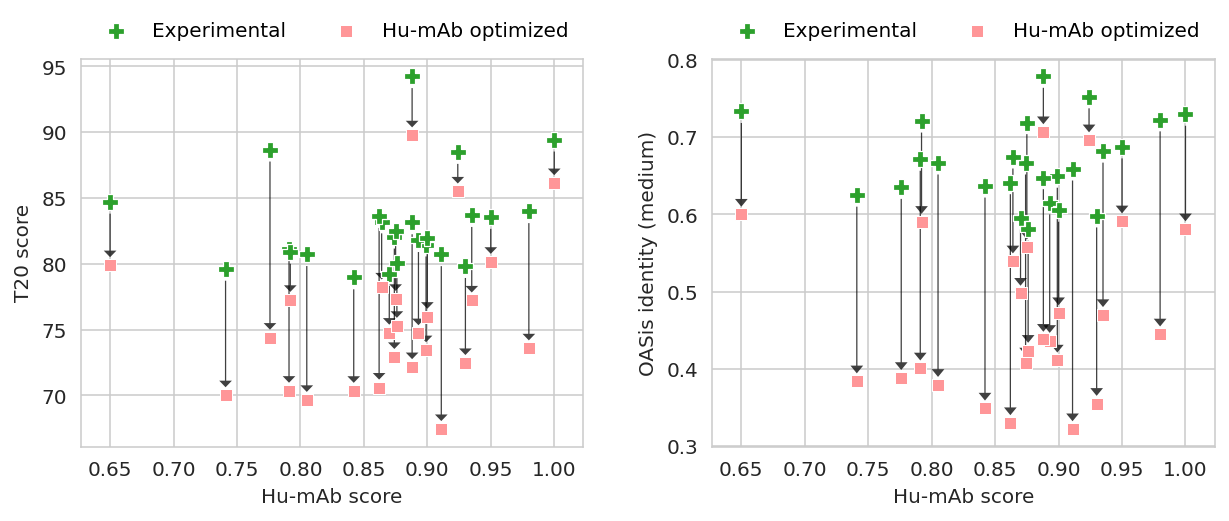

In [57]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax = axes[0]
x = humab_scores['Target Score']
y1 = t20_heatmap.loc[EXPERIMENTAL['name']].loc[humab_scores.index]
y2 = t20_heatmap.loc[HUMAB['name']].loc[humab_scores.index]
sns.scatterplot(
    x=humab_scores['Target Score'],
    y=y1,
    label=EXPERIMENTAL['name'],
    color=EXPERIMENTAL['color'],
    marker='P',
    s=60,
    ax=ax,
    zorder=1000, 
)
sns.scatterplot(
    x=humab_scores['Target Score'],
    y=y2,
    label='Hu-mAb optimized',
    color=HUMAB['color'],
    marker='s',
    s=40,
    ax=ax,
    zorder=1000, 
);
for i in range(len(x)):
    ax.arrow(x[i], y1[i]-0.9, 0, y2[i]-y1[i]+1.5, color='black', width=0.001, alpha=0.75,
             head_width=0.01, head_length=0.5, lw=0, length_includes_head=True)
print('T20', y1.mean(), y2.mean())

ax.set_xlabel('Hu-mAb score')
ax.set_ylabel('T20 score');
ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1), frameon=False);

ax = axes[1]
x = humab_scores['Target Score']
y1 = oasis_curves.set_index(['Method','Antibody'])['50%'].loc[EXPERIMENTAL['name']].loc[humab_scores.index]
y2 = oasis_curves.set_index(['Method','Antibody'])['50%'].loc[HUMAB['name']].loc[humab_scores.index]
sns.scatterplot(
    x=x,
    y=y1,
    label=EXPERIMENTAL['name'],
    color=EXPERIMENTAL['color'],
    marker='P',
    s=60,
    ax=ax,
    zorder=1000, 
)
sns.scatterplot(
    x=humab_scores['Target Score'],
    y=y2,
    label='Hu-mAb optimized',
    color=HUMAB['color'],
    marker='s',
    s=40,
    ax=ax,
    zorder=1000, 
);
for i in range(len(x)):
    ax.arrow(x[i], y1[i]-0.015, 0, y2[i]-y1[i]+0.025, color='black', width=0.001, alpha=0.75,
             head_width=0.01, head_length=0.01, lw=0, length_includes_head=True)
print('OASis', y1.mean(), y2.mean())

ax.set_xlabel('Hu-mAb score')
ax.set_ylabel('OASis identity (medium)');
ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1), frameon=False);

fig.tight_layout(pad=2);


In [58]:
import json

with open('/Users/prihodad/Downloads/germlines.json') as f:
    d = json.load(f)

In [59]:
examples = []
for n, v in d['genes'].items():
    for example in v['examples']:
        examples.append(example)

In [60]:
df = pd.DataFrame(examples)
for col in df.columns:
    df[col] = df[col].astype(str)
    print(col+':', ', '.join(df[col].unique()) if df[col].nunique() <= 15 else ', '.join(df[col].unique()[:15])+'...')

Therapeutic: Sifalimumab, Tralokinumab, Brodalumab, Demcizumab, Evolocumab, Tildrakizumab, Emactuzumab, Lumretuzumab, Monalizumab, Navivumab, Rovalpituzumab, Elezanumab, Cibisatamab, Ontamalimab, Sotrovimab...
Species: Human, Humanized, Human/Humanized
Format: Whole mAb, Whole mAb ADC, Bispecific mAb with Domain Crossover, Bispecific mAb, Fab, Fab + di-Fc, Bispecific Mixed mAb and scFv
CH1 Isotype: G1, G4, G2, G4;G4, G1;na, M
VD LC: Kappa, Lambda, Kappa;Lambda, Lambda;Kappa, Kappa;Kappa
Highest_Clin_Trial (Jan '20): Phase-II, Phase-III, Approved, Phase-I, Phase-I/II, Preclinical, Phase-II/III, TBC, Preregistration, Unknown, Preregistration (w)
Est. Status: Discontinued, Active, NFD, Unknown
Year Proposed: 2009, 2011, 2012, 2014, 2015, 2016, 2017, 2018, 2020, 2010, 2013, 2019, 2008, 1994, 2002...
Year Recommended: 2010, 2012, 2013, 2015, 2016, 2017, 2018, 2019, na, 2011, 2014, 2009, 1998, 2003, 2008...
Target: IFNA1, IL13, IL17RA, DLL4, PCSK9, IL23A, CSF1R, ERBB3, KLRC1, Influenza A HA,

# Humanness-Preservation Tradeoff

In [61]:
preservation = positions.groupby(['Method','name'])['conservation'].value_counts(normalize=True).unstack()[['Back-mutated','Conserved']].sum(axis=1)
preservation

Method         name          
Experimental   AntiCD28          0.767241
               Bevacizumab       0.821739
               Campath           0.767544
               Certolizumab      0.773333
               Clazakizumab      0.786957
                                   ...   
Vernier graft  Reslizumab        0.829596
               Rovalpituzumab    0.817778
               Solanezumab       0.870536
               Talacotuzumab     0.866953
               Tocilizumab       0.845133
Length: 225, dtype: float64

In [62]:
vernier_preservation = vernier_positions.groupby(['Method','name'])['conservation'].value_counts(normalize=True).unstack()[['Back-mutated','Conserved']].sum(axis=1)
vernier_preservation

Method         name          
Experimental   AntiCD28          0.700000
               Bevacizumab       0.900000
               Campath           0.800000
               Certolizumab      0.966667
               Clazakizumab      0.800000
                                   ...   
Vernier graft  Reslizumab        1.000000
               Rovalpituzumab    1.000000
               Solanezumab       1.000000
               Talacotuzumab     1.000000
               Tocilizumab       1.000000
Length: 225, dtype: float64

In [63]:
tradeoff = pd.DataFrame({
        'Preservation': preservation,
        'Vernier preservation': vernier_preservation,
        'OASis identity': oasis_curves.set_index(['Method', 'Antibody'])['50%'],
        'T20 score': t20_scores.set_index(['Method', 'Antibody'])['t20'],
})
tradeoff.index.names = ('Method', 'Antibody')
tradeoff['OASis improvement'] = tradeoff.apply(
    lambda row: row['OASis identity'] - tradeoff['OASis identity'].loc[(PARENTAL['name'], row.name[1])],
    axis=1
)
tradeoff['T20 improvement'] = tradeoff.apply(
    lambda row: row['T20 score'] - tradeoff['T20 score'].loc[(PARENTAL['name'], row.name[1])],
    axis=1
)
tradeoff.head()

Preservation  Vernier preservation  OASis identity  \
Method       Antibody                                                           
Experimental AntiCD28          0.767241              0.700000        0.666667   
             Bevacizumab       0.821739              0.900000        0.649533   
             Campath           0.767544              0.800000        0.636792   
             Certolizumab      0.773333              0.966667        0.641148   
             Clazakizumab      0.786957              0.800000        0.658879   

                           T20 score  OASis improvement  T20 improvement  
Method       Antibody                                                     
Experimental AntiCD28      80.728035           0.351852         18.07405  
             Bevacizumab   81.455470           0.369159          9.64155  
             Campath       78.961085           0.231132          7.00955  
             Certolizumab  83.621170           0.473684         14.05730  
             Clazakizumab  80.719770           0.412433         16.18560

In [64]:
mean_tradeoff = tradeoff.groupby(level=0).mean()
mean_tradeoff

Preservation  Vernier preservation  OASis identity  T20 score  \
Method                                                                          
Experimental        0.802685              0.857333        0.667773  83.107571   
Hu-mAb              0.889554              0.909287        0.471027  75.588536   
Parental            1.000000              1.000000        0.329529  69.991313   
Sapiens*1           0.884536              0.897333        0.626804  80.158725   
Sapiens*2           0.863539              0.868000        0.662970  81.800763   
Sapiens*3           0.857036              0.860000        0.669764  82.369028   
Sapiens*4           0.855624              0.858667        0.672253  82.539287   
Straight graft      0.826866              0.797333        0.690248  83.773132   
Vernier graft       0.853212              0.998667        0.648145  81.367926   

                OASis improvement  T20 improvement  
Method                                              
Experimental             0.338245        13.116259  
Hu-mAb                   0.141498         5.597223  
Parental                 0.000000         0.000000  
Sapiens*1                0.297276        10.167412  
Sapiens*2                0.333441        11.809450  
Sapiens*3                0.340235        12.377715  
Sapiens*4                0.342724        12.547975  
Straight graft           0.360719        13.781819  
Vernier graft            0.318616        11.376613

In [65]:
def plot_tradeoff(data, ax=None, s=50, text=True, ticklim=None, markers=False, tickstep=0.1, legend=False, **kwargs):
    x = data.iloc[:,0]
    y = data.iloc[:,1]
    ax = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue='Method',
        style='Method' if markers else None,
        markers=markers,
        palette=COLORS,
        legend=legend,
        s=s,
        ax=ax,
        **kwargs
    )
    ax.grid(False)
    if text:
        for method, row in data.iterrows():
            if method == PARENTAL['name']:
                ax.text(row[0], row[1], '  '+method, fontsize=11, ha='left', va='center')
            else:
                ax.text(row[0], row[1], method+'  ', fontsize=11, ha='right', va='center')
    
    ax.set_yticks(ax.get_yticks());
    if ticklim is not None:
        xmin, xmax = ticklim
    else:
        xmin = (ax.get_xlim()[0]*100//5*5)/100
        xmax = ax.get_xlim()[1]
    xticks = np.arange(xmin, xmax+0.01, tickstep)
    ax.set_xticks(xticks);
    ax.set_yticklabels([f'{v:.0%}' for v in ax.get_yticks()]);
    ax.set_xticklabels([f'{v:+.0%}' for v in xticks]);
    ax.set_ylim([ax.get_ylim()[0], 1.015])

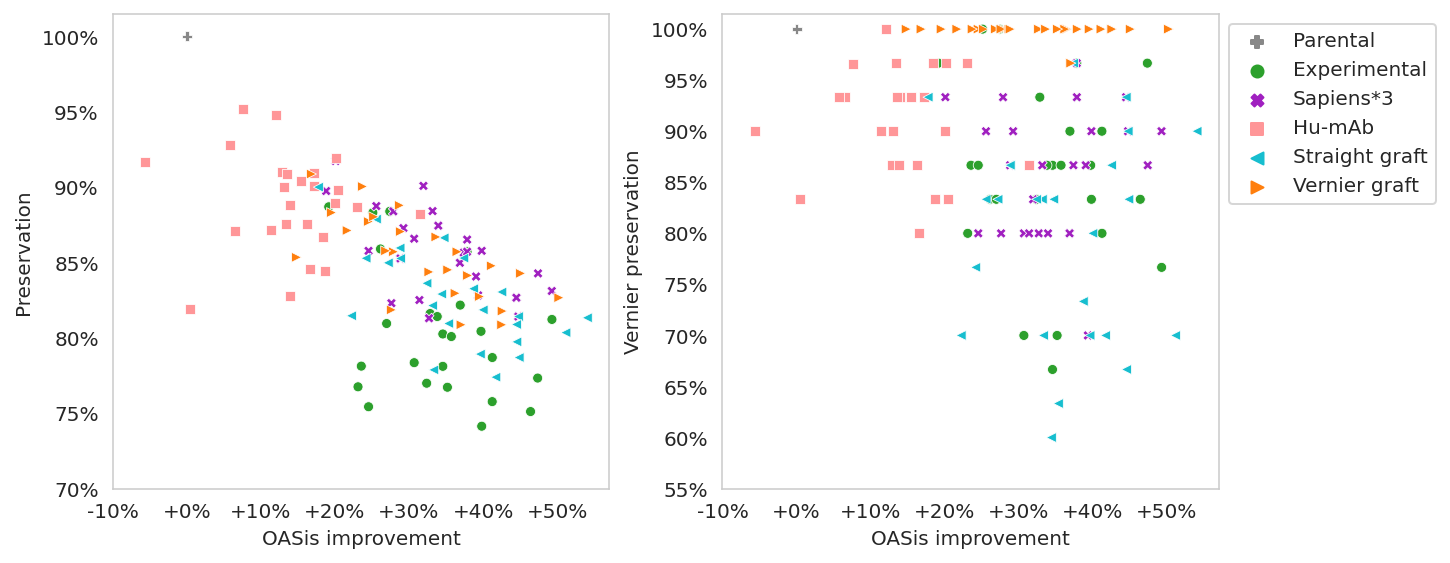

In [66]:
markers = {name: marker for name, marker in zip(SELECTED_COLORS, 'PoXs<>')}
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    df = tradeoff.loc[SELECTED_METHOD_NAMES]
    plot_tradeoff(df[['OASis improvement', 'Preservation']].reset_index(level=1, drop=True), 
                  text=False, markers=markers, s=25, ax=axes[0])
    plot_tradeoff(df[['OASis improvement', 'Vernier preservation']].reset_index(level=1, drop=True), 
                  text=False, markers=markers, s=25, ax=axes[1], legend=True)
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    fig.tight_layout();

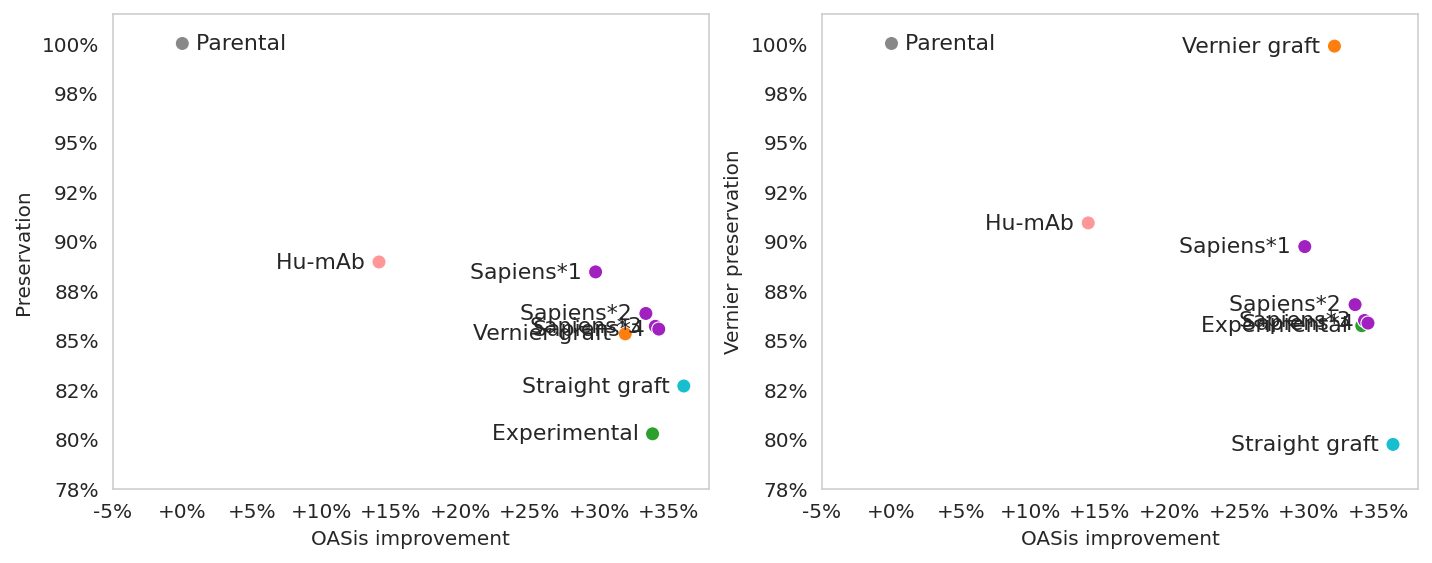

In [67]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_tradeoff(mean_tradeoff[['OASis improvement', 'Preservation']], ax=axes[0], tickstep=0.05)
    plot_tradeoff(mean_tradeoff[['OASis improvement', 'Vernier preservation']], ax=axes[1], tickstep=0.05)
    fig.tight_layout();

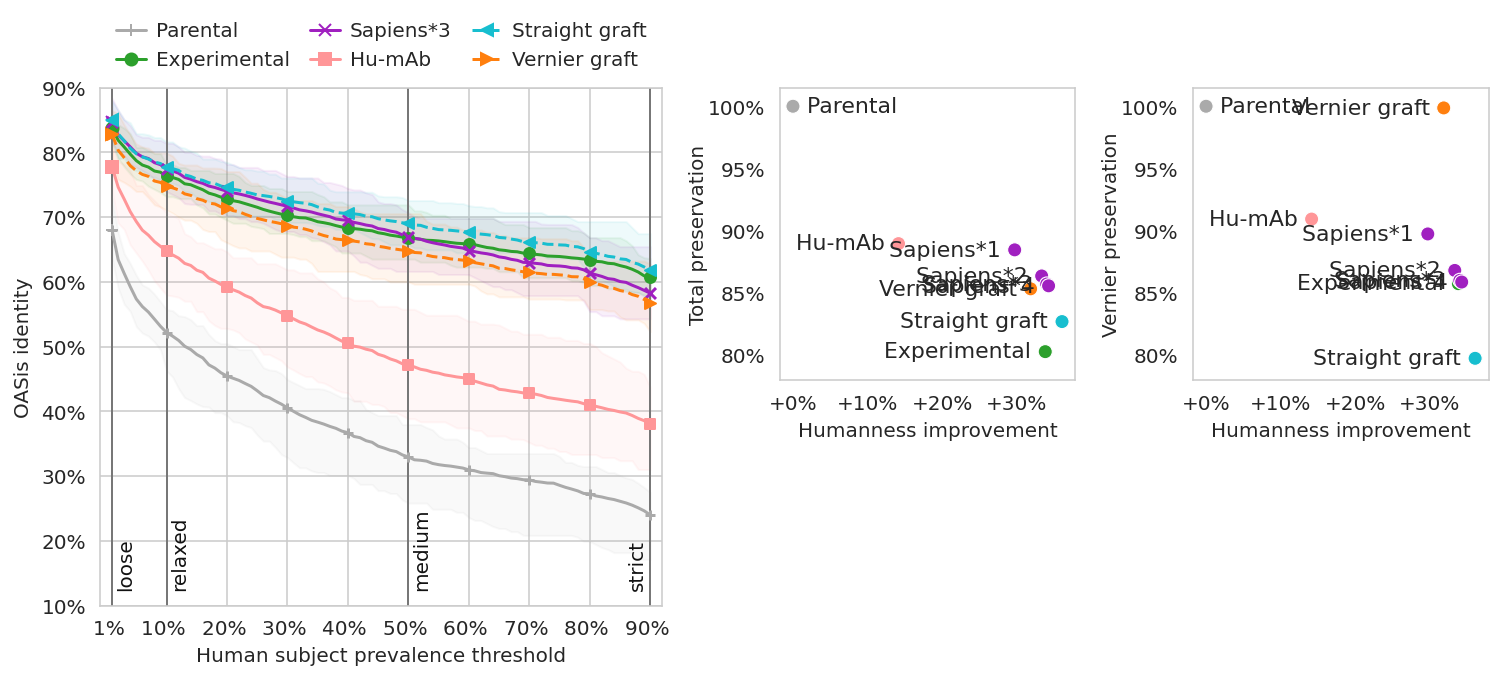

In [73]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10.5, 4.8))
    gs = fig.add_gridspec(2, 3, width_ratios=[1.9, 1, 1], height_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[0, 2])
    ax5 = fig.add_subplot(gs[1, 2])

    ax = ax1
    plot_oasis_curves(
        oasis_curves, 
        groupby='Method', 
        ncol=3, 
        colors=SELECTED_COLORS, 
        linestyles=LINESTYLES, 
        lw=1.5, 
        ylim=(0.1, 0.9),
        markers='+oxs<>',
        fill_alpha=0.07,
        ax=ax
    )
    name = SAPIENS['name']
    colors = {
        'Baseline': COLORS['Experimental'],
        'Prediction': COLORS[name]
    }
    ax3.set_visible(False)
    ax5.set_visible(False)
    
    plot_tradeoff(mean_tradeoff[['OASis improvement', 'Preservation']], ax=ax2, ticklim=(0, 0.35))
    ax2.set_ylim(0.78)
    ax2.set_xlabel('Humanness improvement')
    ax2.set_ylabel('Total preservation')
    ax2.yaxis.labelpad = 0
    
    plot_tradeoff(mean_tradeoff[['OASis improvement', 'Vernier preservation']], ax=ax4, ticklim=(0, 0.35))
    ax4.set_ylim(0.78)
    ax4.set_xlabel('Humanness improvement')
    ax4.yaxis.labelpad = 0

    fig.tight_layout()
    fig.savefig('../../data/figures/main/fig5a.pdf', bbox_inches='tight')

In [69]:
def plot_separate_curves(oasis_curves, rows, cols, subset=None, highlight=None, sharex=False, thresholds=False, figsize=(10, 6)):
    if subset is not None:
        oasis_curves = oasis_curves[oasis_curves['Antibody'].isin(subset)]
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=True, sharex=sharex)
    if rows == 1:
        axes = [axes]
        
    for i in range(rows):
        for j in range(cols):
            axes[i][j].set_visible(False)
    
    for i, (antibody, antibody_curves) in enumerate(oasis_curves.groupby('Antibody')):
        col = i % cols
        row = i // cols
        ax = axes[row][col]
        ax.set_visible(True)
        colors = {n: c for n, c in COLORS.items() if n in antibody_curves['Method'].values}
        linewidths = {n: 2.5 if n == highlight else 1.5 for n in colors} if highlight else {}
        plot_oasis_curves(antibody_curves.set_index('Method'), mark=False,
                          colors=colors, linestyles=LINESTYLES, linewidths=linewidths, thresholds=thresholds, ax=ax)
        ax.legend().remove()
        ax.set_xticks(list(ax.get_xticks())[::2])
        ax.set_yticks(list(ax.get_yticks())[::2])
        ax.set_title(antibody)
        if not sharex or row == rows - 1:
            ax.set_xlabel('Prevalence threshold')
        else:
            ax.set_xlabel('')
        if col != 0:
            ax.set_ylabel('')
    fig.tight_layout();

# OASis humanness per sequence

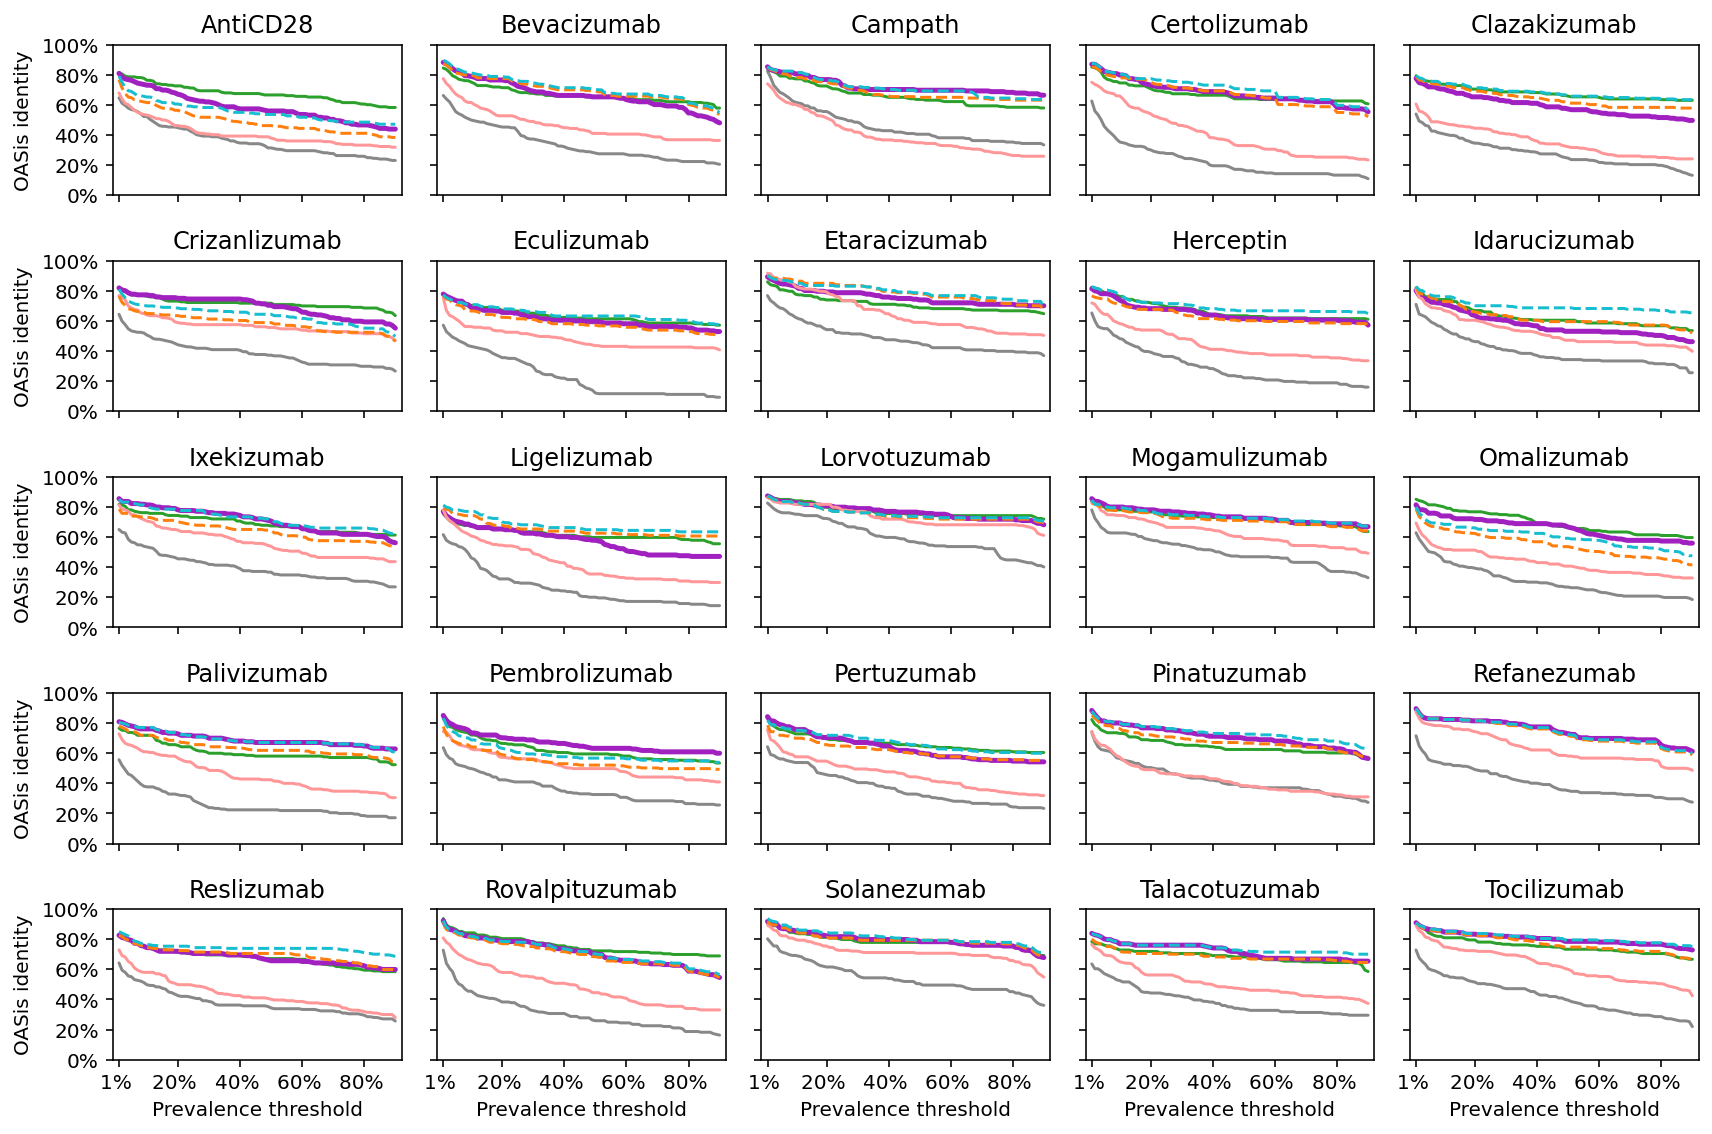

In [70]:
plot_separate_curves(
    oasis_curves[oasis_curves['Method'].isin(SELECTED_METHOD_NAMES)], 
    5, 
    5, 
    figsize=(12, 8), 
    sharex=True,
    highlight=SAPIENS['name']
)

# Result table

In [71]:
table = pd.DataFrame({
    ('Humanness improvement', 'OASis (medium)'): mean_tradeoff['OASis improvement'],
    ('Humanness improvement', 'T20'): mean_tradeoff['T20 improvement'] / 100,
    ('Parental preservation', 'Total'): mean_tradeoff['Preservation'],
    ('Parental preservation', 'Vernier'): mean_tradeoff['Vernier preservation'],
    ('Mutation precision', 'Total'): precision,
    ('Mutation precision', 'Vernier'): vernier_precision
})
table = table.drop([PARENTAL['name']])
table.apply({
    table.columns[0]: lambda col: col.apply('{:+.1%}'.format),
    table.columns[1]: lambda col: col.apply('{:+.1%}'.format),
    table.columns[2]: lambda col: col.apply('{:.1%}'.format),
    table.columns[3]: lambda col: col.apply('{:.1%}'.format),
    table.columns[4]: lambda col: col.apply('{:.1%}'.format),
    table.columns[5]: lambda col: col.apply('{:.1%}'.format)
})

Humanness improvement         Parental preservation          \
                      OASis (medium)     T20                 Total Vernier   
Method                                                                       
Experimental                  +33.8%  +13.1%                 80.3%   85.7%   
Hu-mAb                        +14.1%   +5.6%                 89.0%   90.9%   
Sapiens*1                     +29.7%  +10.2%                 88.5%   89.7%   
Sapiens*2                     +33.3%  +11.8%                 86.4%   86.8%   
Sapiens*3                     +34.0%  +12.4%                 85.7%   86.0%   
Sapiens*4                     +34.3%  +12.5%                 85.6%   85.9%   
Straight graft                +36.1%  +13.8%                 82.7%   79.7%   
Vernier graft                 +31.9%  +11.4%                 85.3%   99.9%   

               Mutation precision          
                            Total Vernier  
Method                                     
Experimental               100.0%  100.0%  
Hu-mAb                      71.6%   54.4%  
Sapiens*1                   76.7%   49.4%  
Sapiens*2                   74.3%   42.4%  
Sapiens*3                   72.7%   40.0%  
Sapiens*4                   72.3%   39.6%  
Straight graft              64.8%   34.9%  
Vernier graft               70.2%  100.0%